# Preprocessing and registration
This notebook does basic preprocessing and registration dragonfly multiresolution data

# Notes
I think I could improve results by padding the low res image with black on either side. I did this with the atlas mapping too

Note, I think that for the high res channel 0 is cell label. for high res, channel 1 is cell label

v00 is just getting set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join,split,splitext
import time

import imp
import donglab_workflows as dw
imp.reload(dw)
from scipy.interpolate import interpn

In [2]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [3]:
# where should outputs go?
output_prefix = 'dragonfly_tme07_10_to_30_outputs_v00/'

In [4]:
output_directory = split(output_prefix)[0]
if output_directory:
    os.makedirs(output_directory,exist_ok=True)

In [5]:
# load target image
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_02A_channel_1_down.npz'
# done, no problem
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_02B_channel_1_down.npz'
# no problem

# go to 03
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_03A_channel_1_down.npz'
# ok fine
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_03B_channel_1_down.npz'
# ok fine

# go to 04
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_04A_channel_1_down.npz'
# ok fine
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_04B_channel_1_down.npz'
# ok

# 05
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_05A_channel_1_down.npz'
# ok
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_05B_channel_1_down.npz'
# ok


# 06
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_06A_channel_0_down.npz'
# having some trouble with initial alignment
# BAD currently
# okay I think i fixed it
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_06B_channel_0_down.npz'
# ok

# 07
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_07A_channel_0_down.npz'
# ok
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_07B_channel_0_down.npz'
# ok

# 08
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_08A_channel_0_down.npz'
# ok
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_08B_channel_0_down.npz'
# ok

#09
#target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_09A_channel_0_down.npz'
# there is no A here, only B
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_09B_channel_0_down.npz'
# for this last one the registration does not look very good





In [6]:
target_name

'/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_09B_channel_0_down.npz'

In [7]:
target_data = np.load(target_name,allow_pickle=True)

In [8]:
J = target_data['I'][None]
J = J.astype(np.float32)
J -= np.quantile(J[target_data['W'][None]>0.9],0.001)
J /= np.quantile(J[target_data['W'][None]>0.9],0.999)
J[target_data['W'][None]<=0.90] = 0.0
xJ = target_data['xI']
dJ = [x[1] - x[0] for x in xJ]
J0 = np.copy(J)

<IPython.core.display.Javascript object>


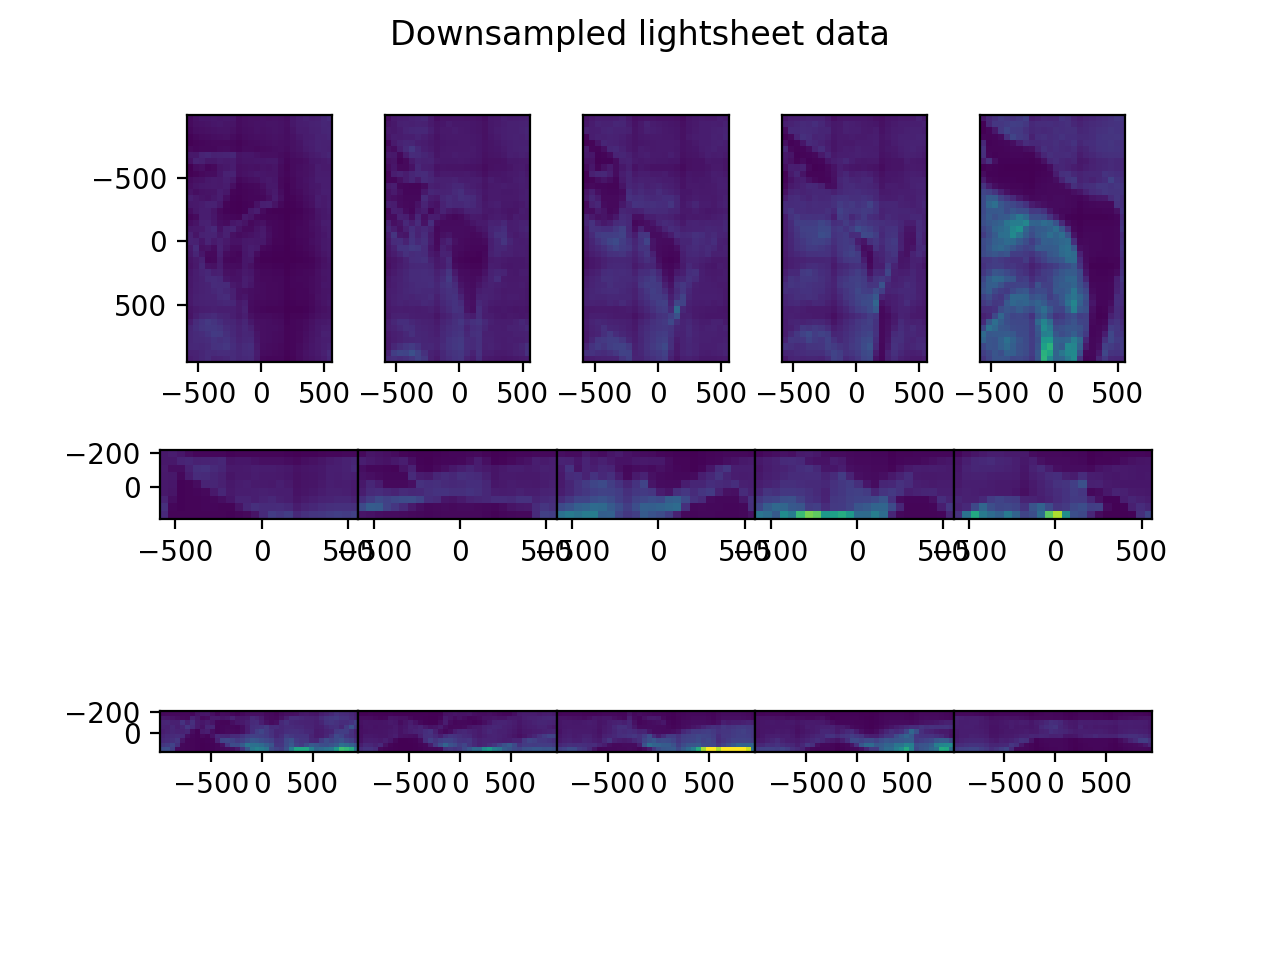

4294967296 4294967296


In [9]:
fig,ax = emlddmm.draw(J,xJ,vmin=0,vmax=1)
fig.suptitle('Downsampled lightsheet data')
figopts = {'dpi':300,'quality':90}
fig.savefig(output_prefix + 'downsampled.jpg',**figopts)

In [10]:
# load atlas images
#atlas_names = [
#    '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_10x_02_channel_1_down.npz'    
#]
# instead of hard coding this, let's search for it
target_key = splitext(split(target_name)[-1])[0].split('_')[-4]
atlas_root = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/'
atlas_names = glob(join(atlas_root,'*10x_'+target_key[:2]+'*channel_1*.npz'))
#atlas_names = glob(join(atlas_root,'*10x_'+target_key[:2]+'*channel_0*.npz'))

In [11]:
I = []
for atlas_name in atlas_names:
    atlas_data = np.load(atlas_name,allow_pickle=True)
    xI = atlas_data['xI']
    I_ = atlas_data['I'].astype(np.float32)    
    I_ -= np.quantile(I_[atlas_data['W']>0.9],0.001)
    I_ /= np.quantile(I_[atlas_data['W']>0.9],0.999)
    I_[atlas_data['W']<=0.9] = 0.0
    I.append(I_)
I = np.concatenate(I)    
if I.ndim == 3:
    I = I[None]
dI = [x[1] - x[0] for x in xI]
XI = np.meshgrid(*xI,indexing='ij')

<IPython.core.display.Javascript object>


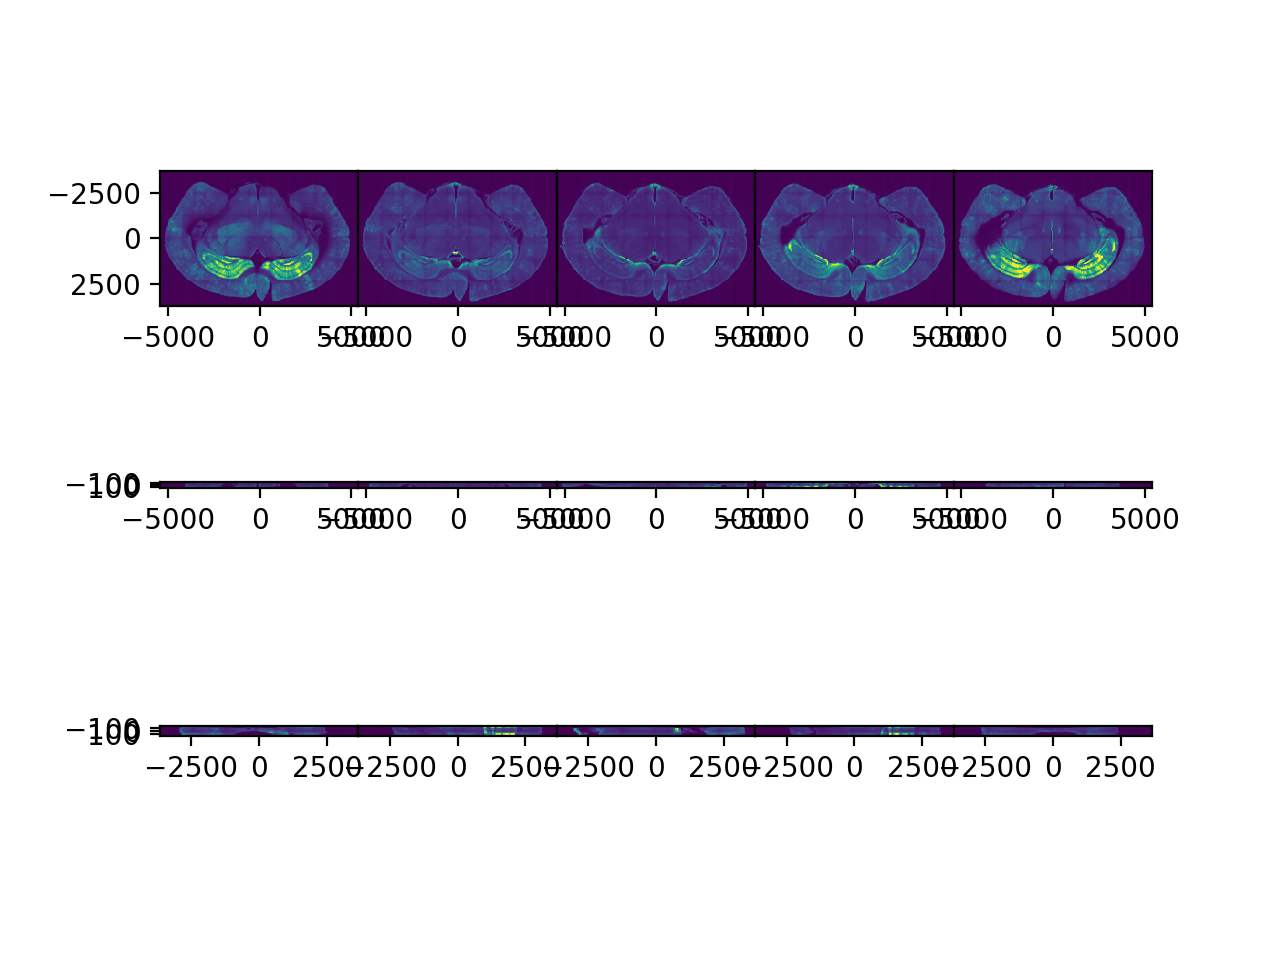

In [12]:
fig,ax = emlddmm.draw(I,xI,vmin=0,vmax=1)
fig.canvas.draw()

# Initial preprocessing



## Target preprocessing

<IPython.core.display.Javascript object>


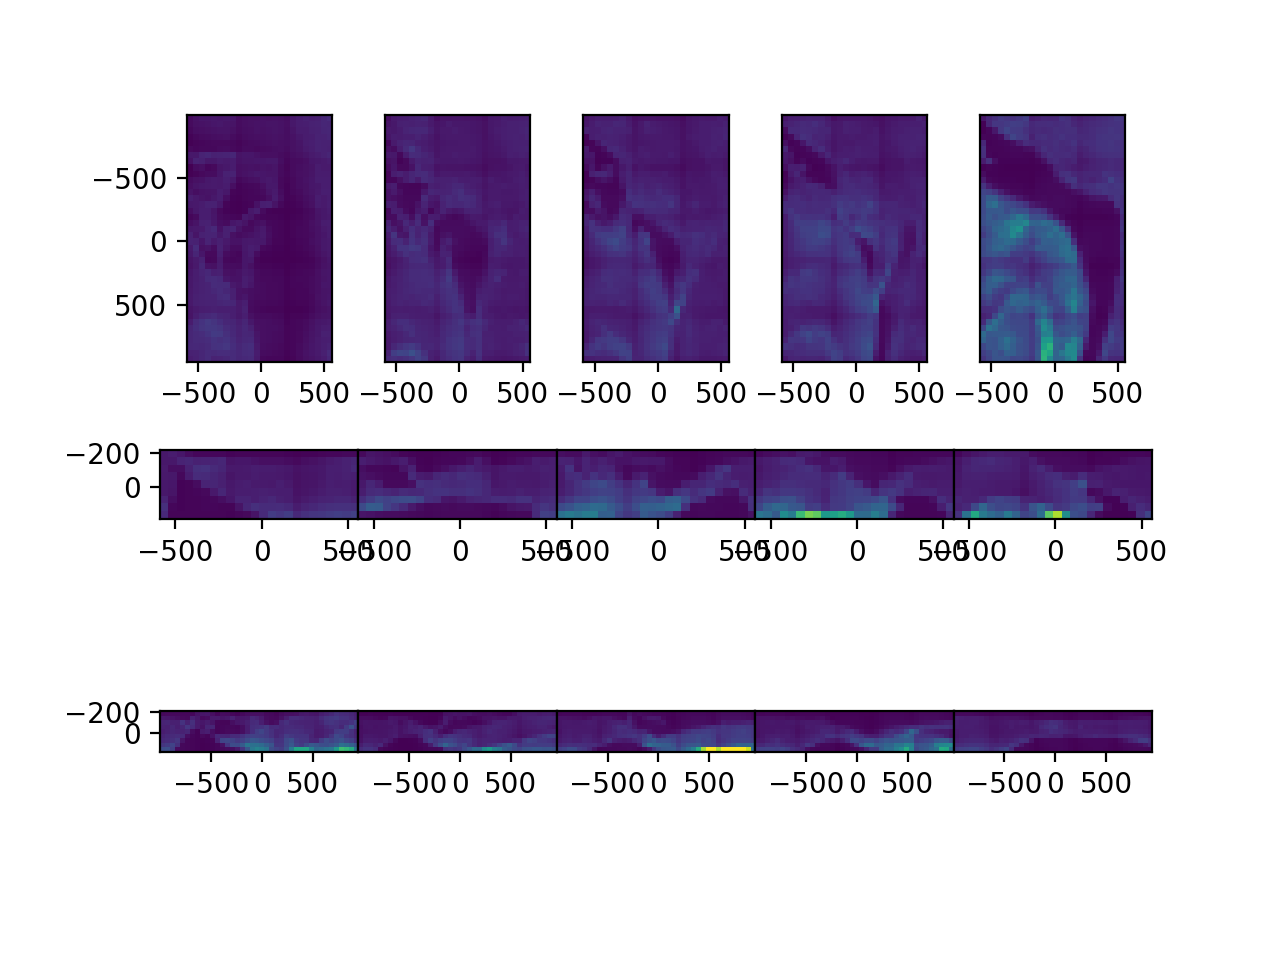

<IPython.core.display.Javascript object>


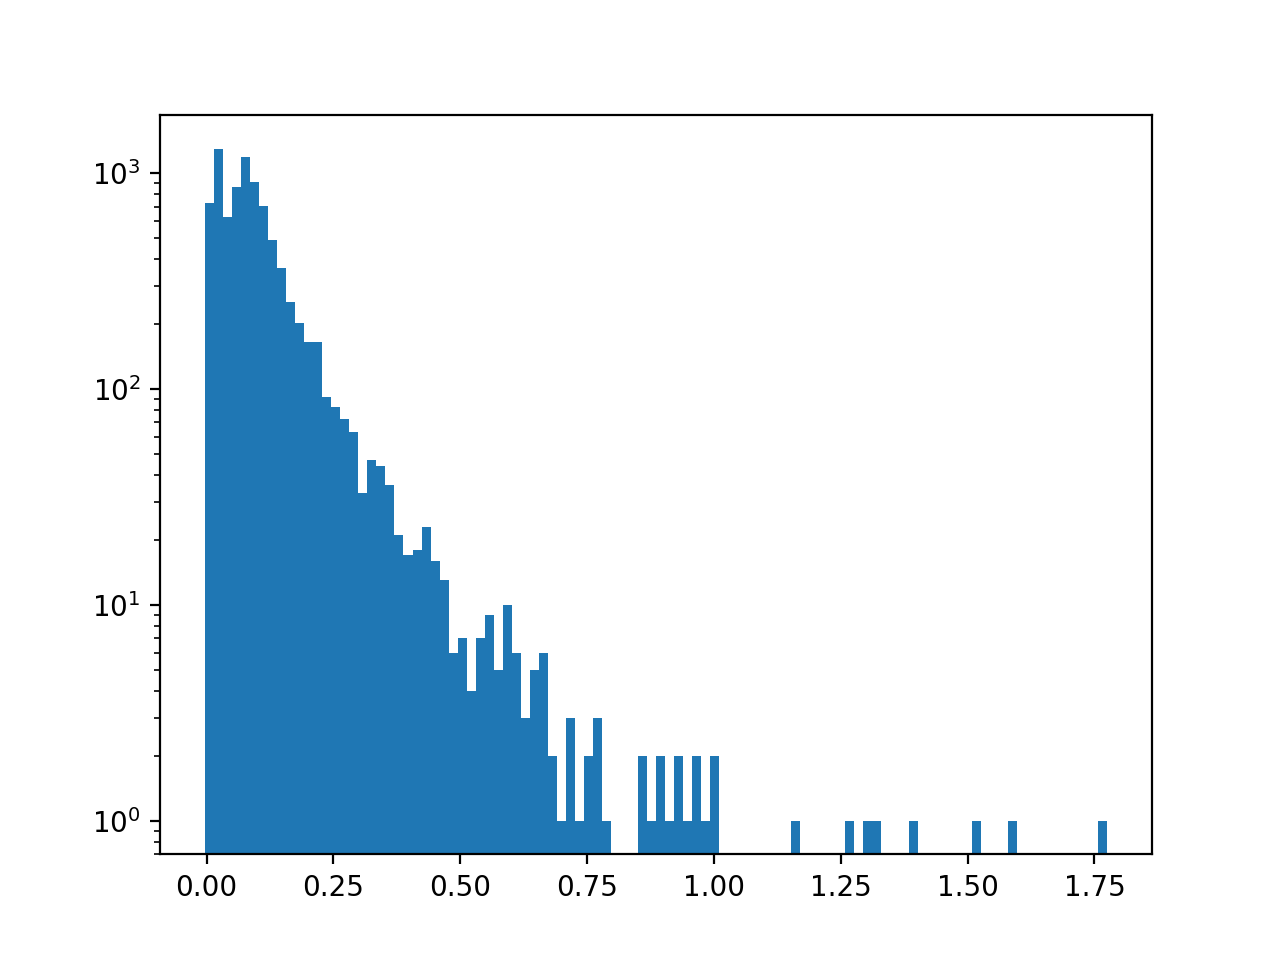

In [13]:
# adjust dynamic range
#J[J<0]=0
#J = J**0.5
# adjust mean value
#J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(J,xJ,vmin=0,vmax=1)
fig.canvas.draw()
fig,ax = plt.subplots()
ax.hist(J.ravel(),100,log=True)
fig.canvas.draw()

## Atlas preprocessing


In [14]:
# pad
# since I will downsample by 4, I want to pad with 4x4x4
npad = 4
I = np.pad(I,  ((0,0),(npad,npad),(npad,npad),(npad,npad)) )
for i in range(npad):
    xI = [ np.concatenate(   (x[0][None]-d,x,x[-1][None]+d)   ) for d,x in zip(dI,xI)]


<IPython.core.display.Javascript object>


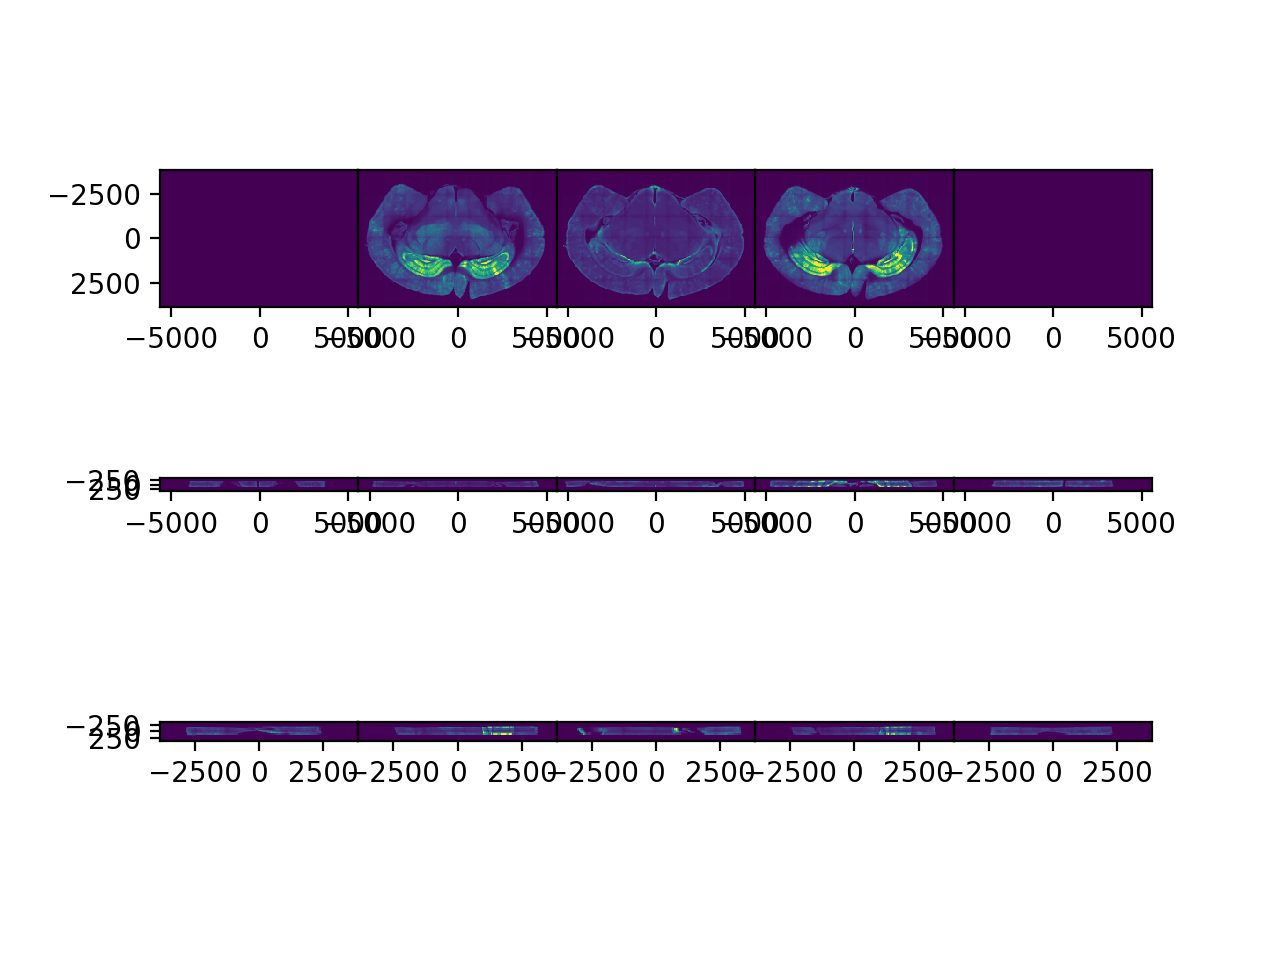

<IPython.core.display.Javascript object>


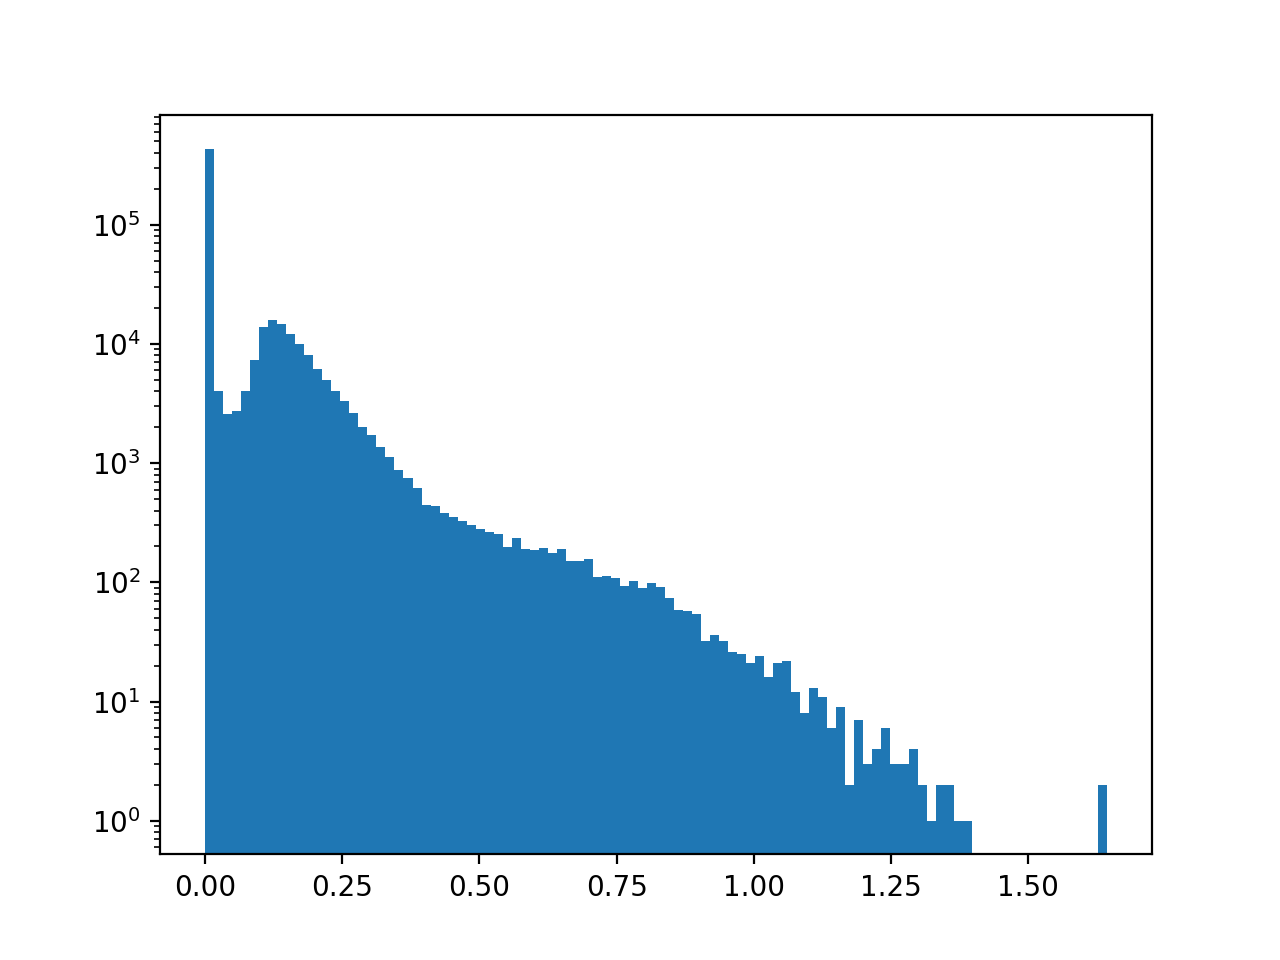

In [15]:
# adjust dynamic range
I[I<0]=0
#I = I**0.5
# adjust mean value
#J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(I,xI,vmin=0,vmax=1)
fig.canvas.draw()
fig,ax = plt.subplots()
ax.hist(I.ravel(),100,log=True)
fig.canvas.draw()

# Registration

In [16]:
print(target_key)

09B


/home/dtward/data/csh_data/emlddmm/emlddmm.py:2541: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  X = torch.as_tensor(X,dtype=self.data.dtype,device=self.data.device)


<IPython.core.display.Javascript object>


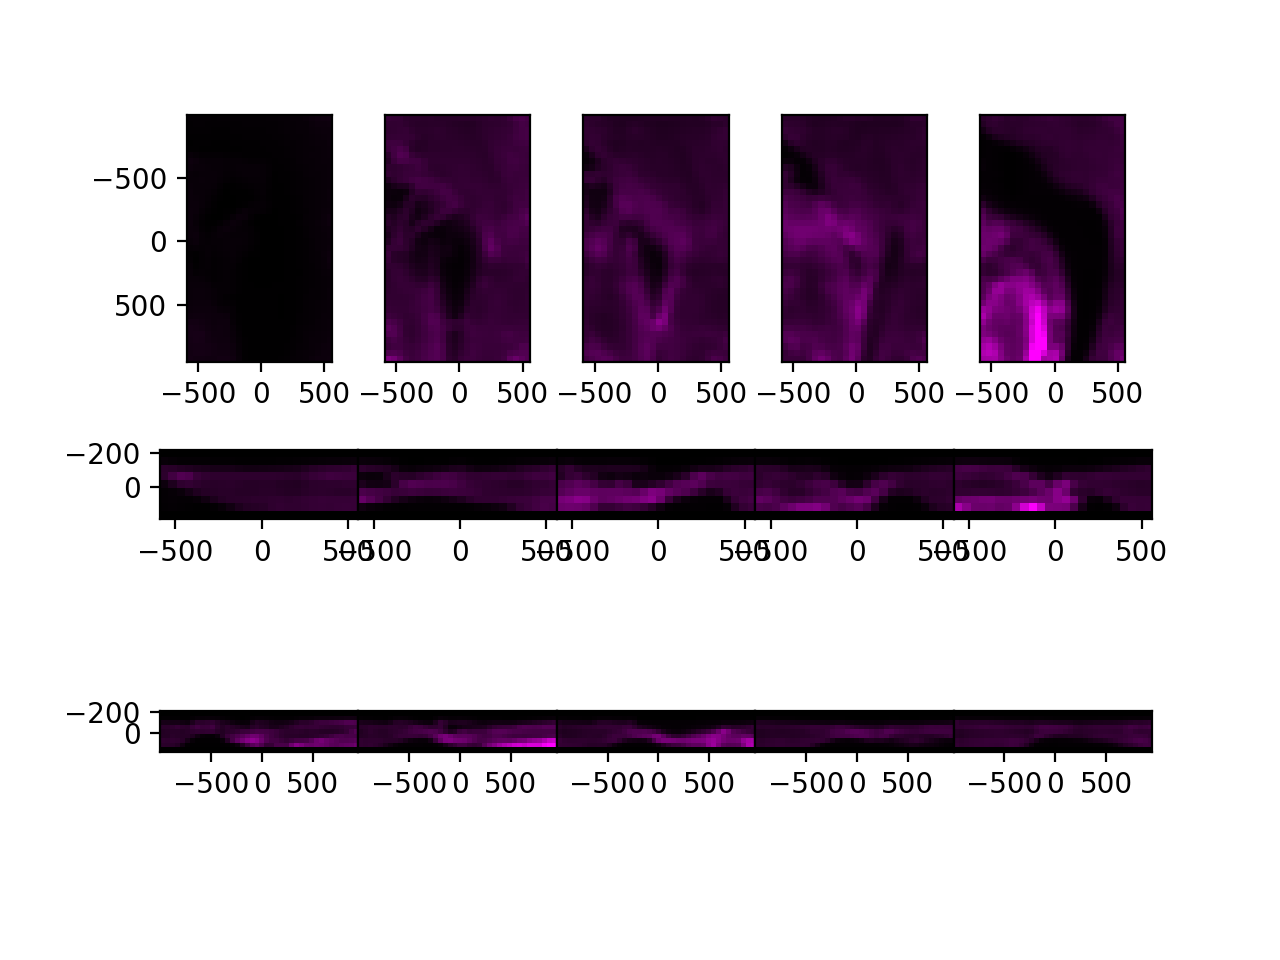

/home/dtward/data/csh_data/emlddmm/emlddmm.py:96: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


In [17]:
# initial affine
# make sure to keep sign of Jacobian
A0 = np.eye(4)
if target_key == '02A':
    A0[0,-1] = 0.0
    A0[1,-1] = 500.0
    A0[2,-1] = 1500.0
elif target_key == '02B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 800.0
    A0[2,-1] = -1500.0
elif target_key == '03A':
    A0[0,-1] = 0.0
    A0[1,-1] = 500.0
    A0[2,-1] = 1800.0
elif target_key == '03B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 500.0
    A0[2,-1] = -1400.0
elif target_key == '04A':
    A0[0,-1] = 0.0
    A0[1,-1] = 500.0
    A0[2,-1] = 2100.0
elif target_key == '04B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 400.0
    A0[2,-1] = -1600.0   
elif target_key == '05A':
    A0[0,-1] = 0.0
    A0[1,-1] = 500.0
    A0[2,-1] = 2300.0
elif target_key == '05B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 500.0
    A0[2,-1] = -2500.0       
elif target_key == '06A':
    A0[0,-1] = 0.0
    A0[1,-1] = -100.0
    A0[2,-1] = 3100.0
elif target_key == '06B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 100.0
    A0[2,-1] = -2600.0
elif target_key == '07A':
    A0[0,-1] = 0.0
    A0[1,-1] = 200
    A0[2,-1] = 3400.0
elif target_key == '07B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 100.0
    A0[2,-1] = -3000.0 
elif target_key == '08A':
    A0[0,-1] = 0.0
    A0[1,-1] = 200
    A0[2,-1] = 3700.0
elif target_key == '08B':    
    A0[0,-1] = 0.0
    A0[1,-1] = 100.0
    A0[2,-1] = -3000.0 
elif target_key == '09B':   # no 09A
    A0[0,-1] = 0.0
    A0[1,-1] = 300.0
    A0[2,-1] = -3400.0     
    
    

# check it
XJ = np.meshgrid(*xJ,indexing='ij')
tform = emlddmm.Transform(A0,direction='b')
A0I = emlddmm.apply_transform_float(xI,I,tform.apply(XJ))
fig,ax = emlddmm.draw(np.concatenate((A0I,J*0)),xJ,vmin=0)
fig.canvas.draw()



/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


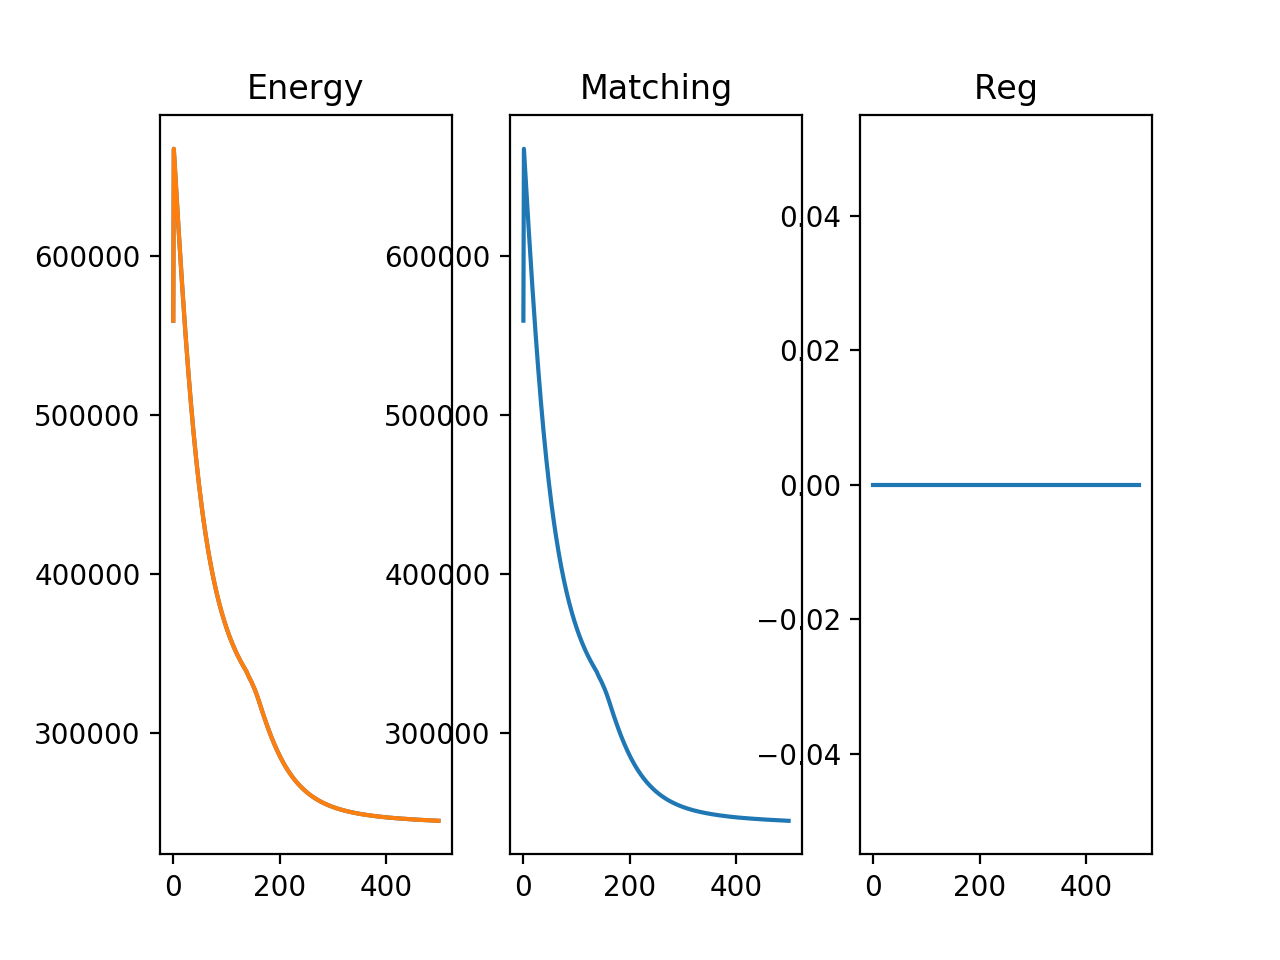

<IPython.core.display.Javascript object>


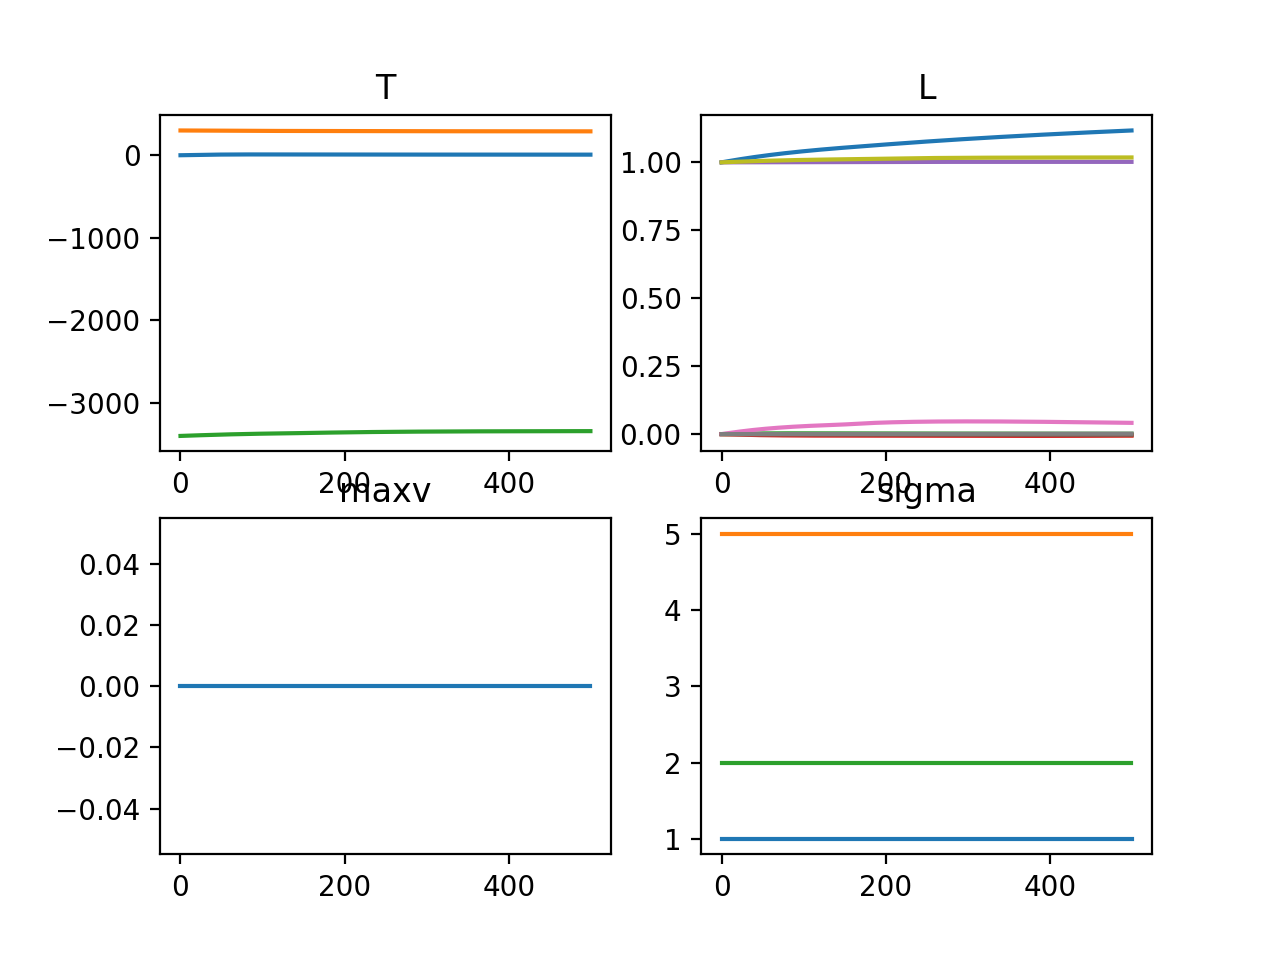

<IPython.core.display.Javascript object>


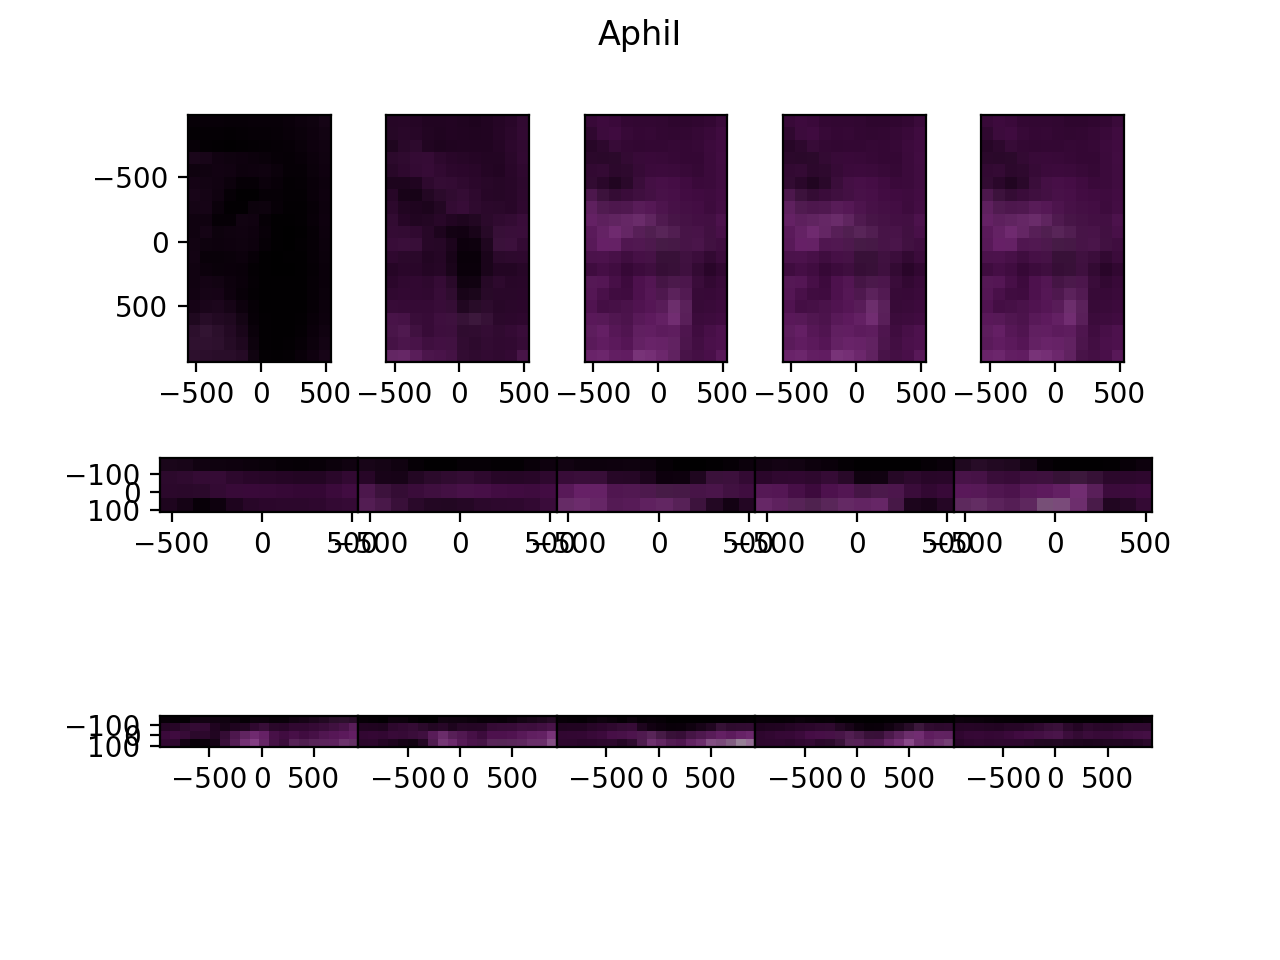

<IPython.core.display.Javascript object>


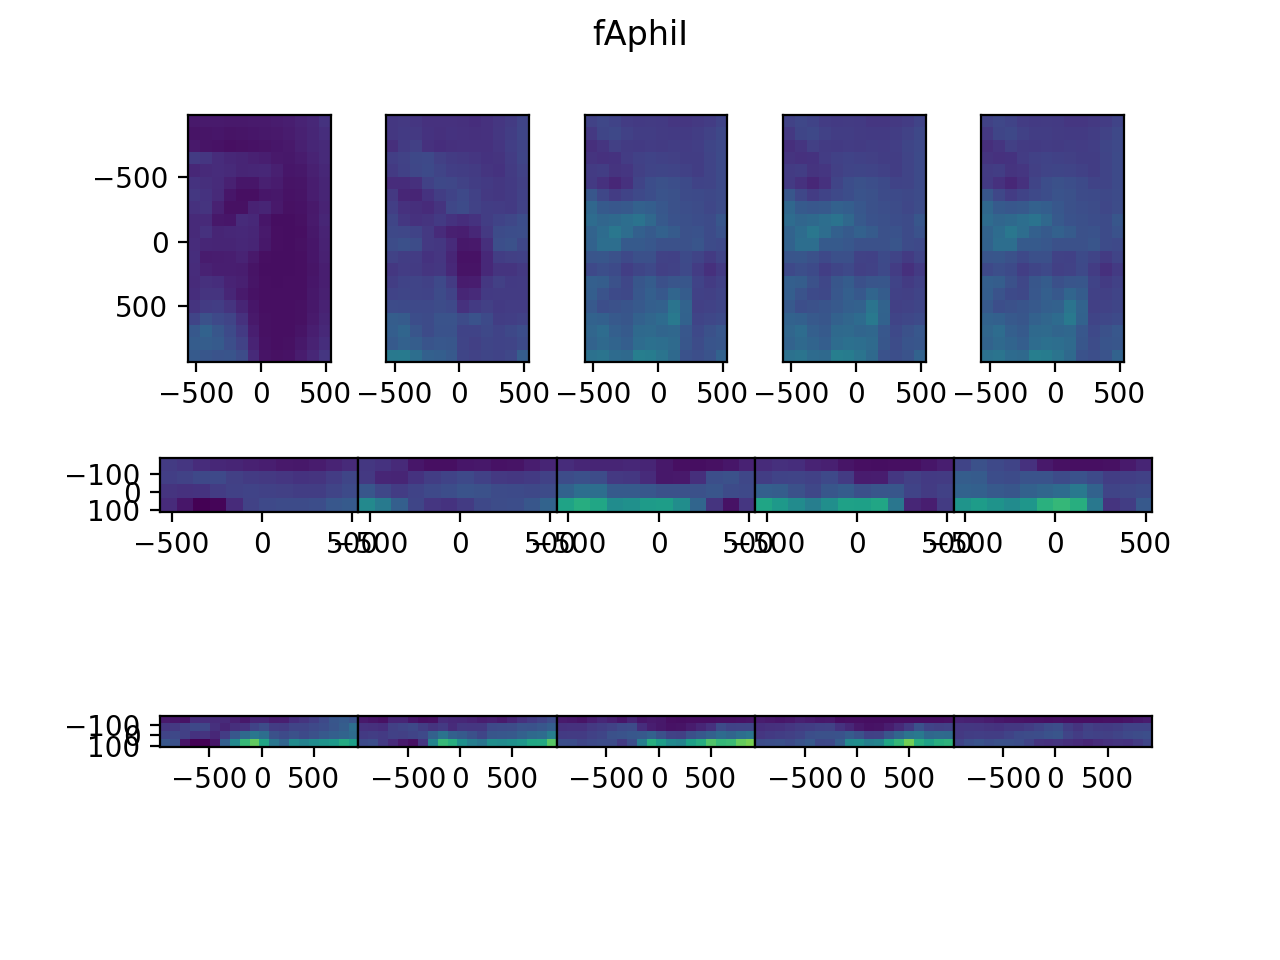

<IPython.core.display.Javascript object>


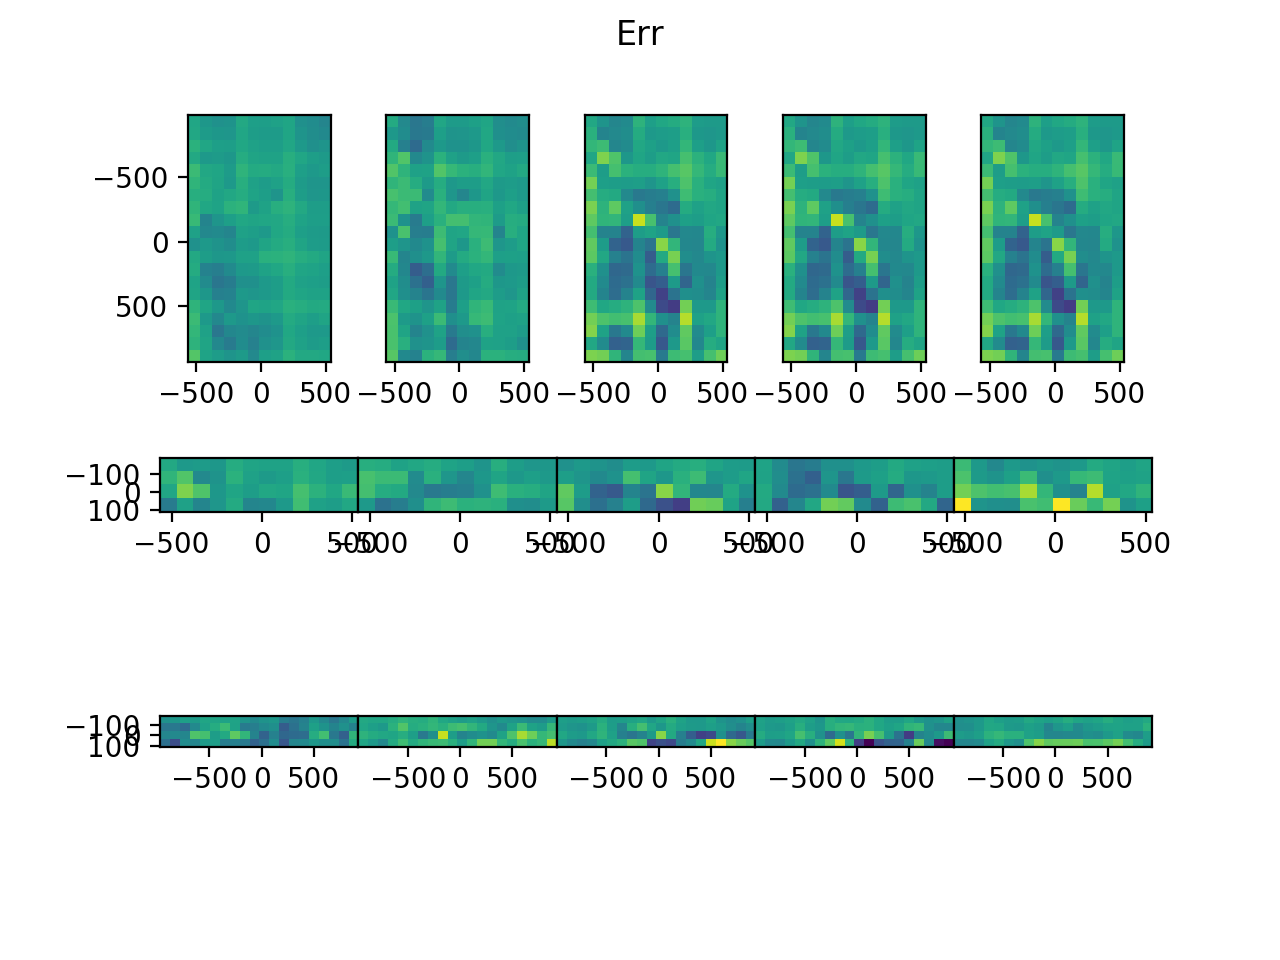

<IPython.core.display.Javascript object>


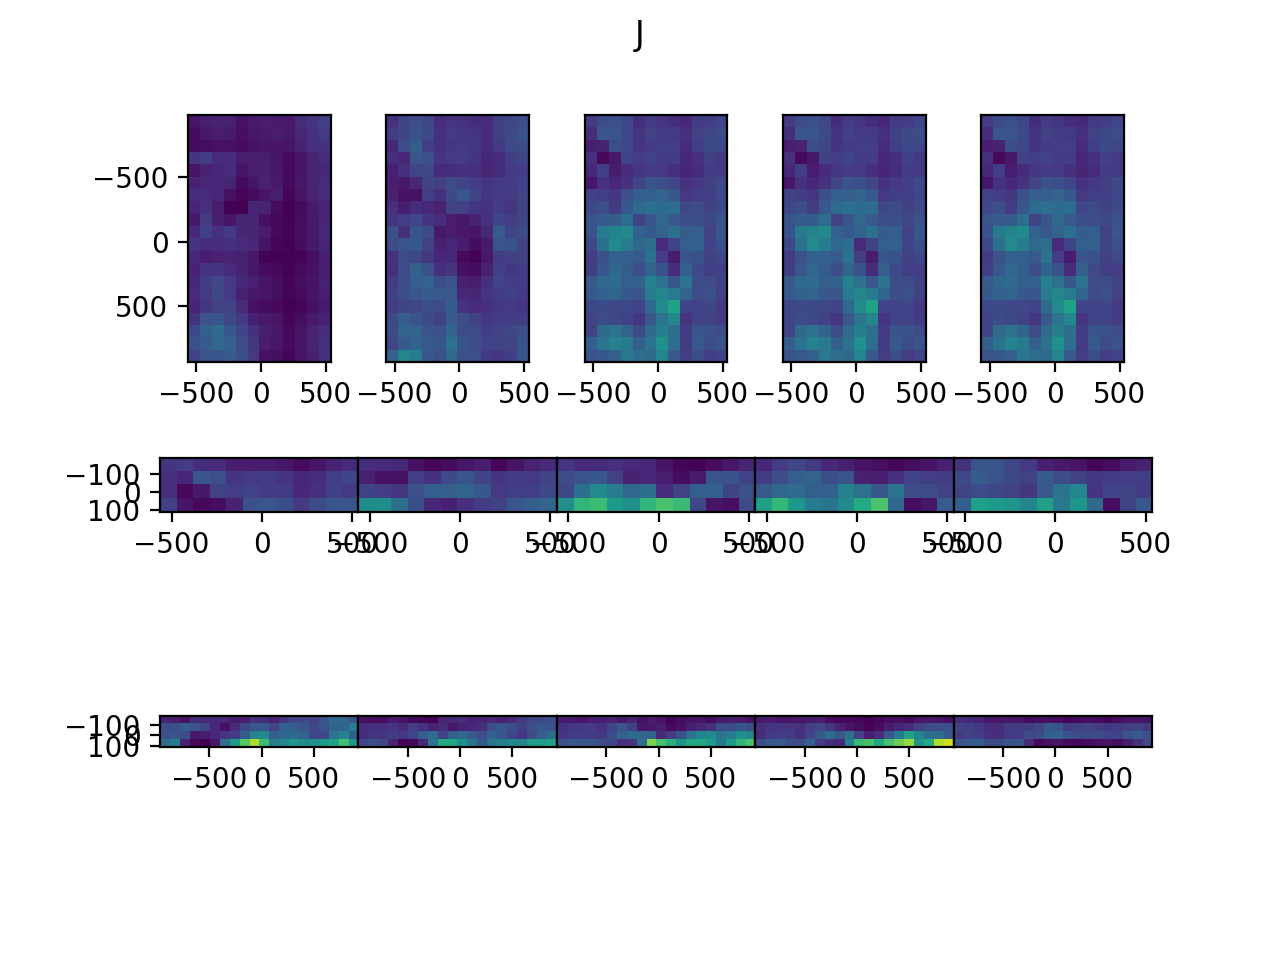

<IPython.core.display.Javascript object>


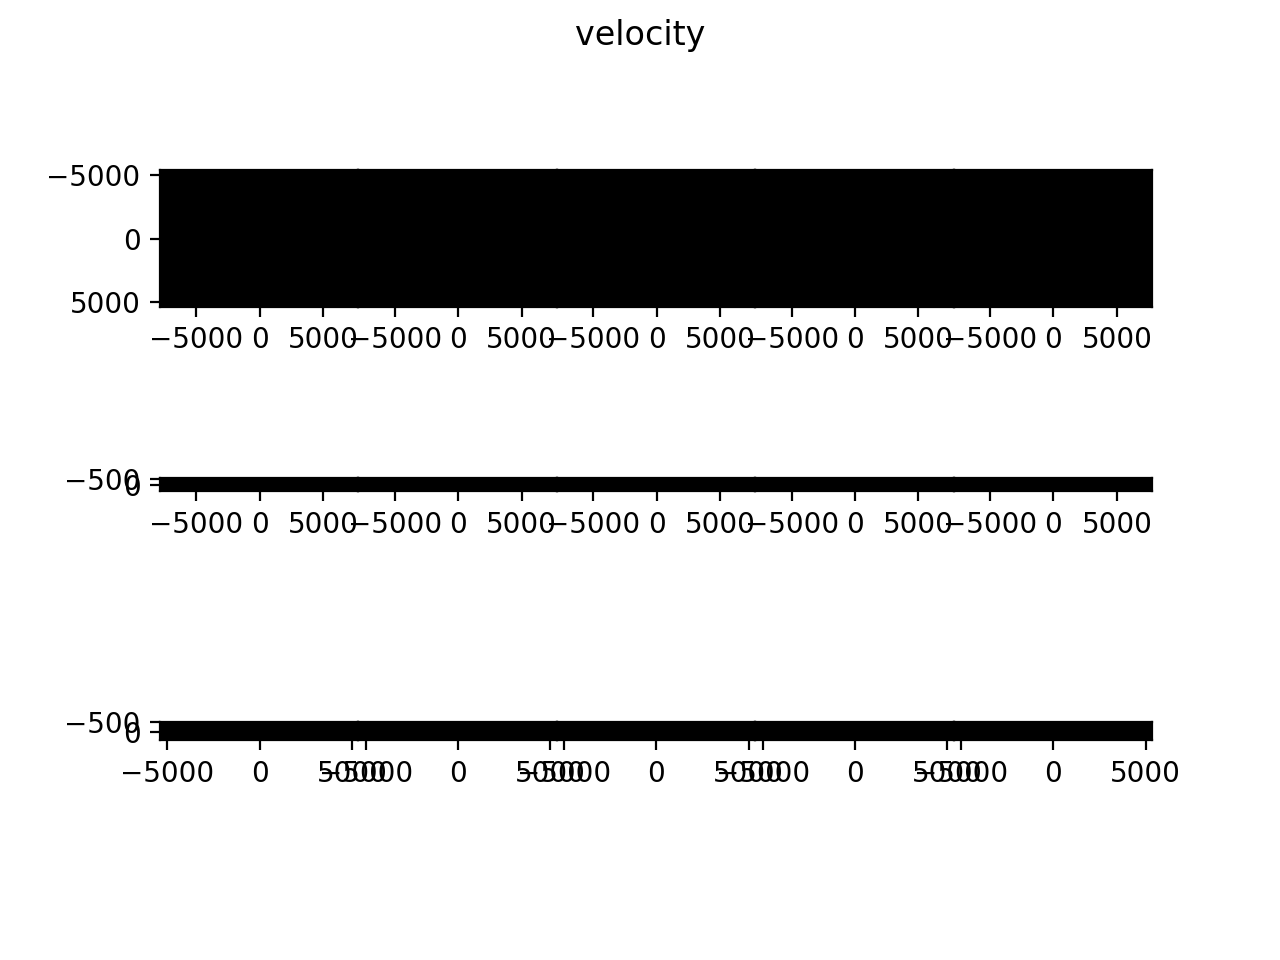

<IPython.core.display.Javascript object>


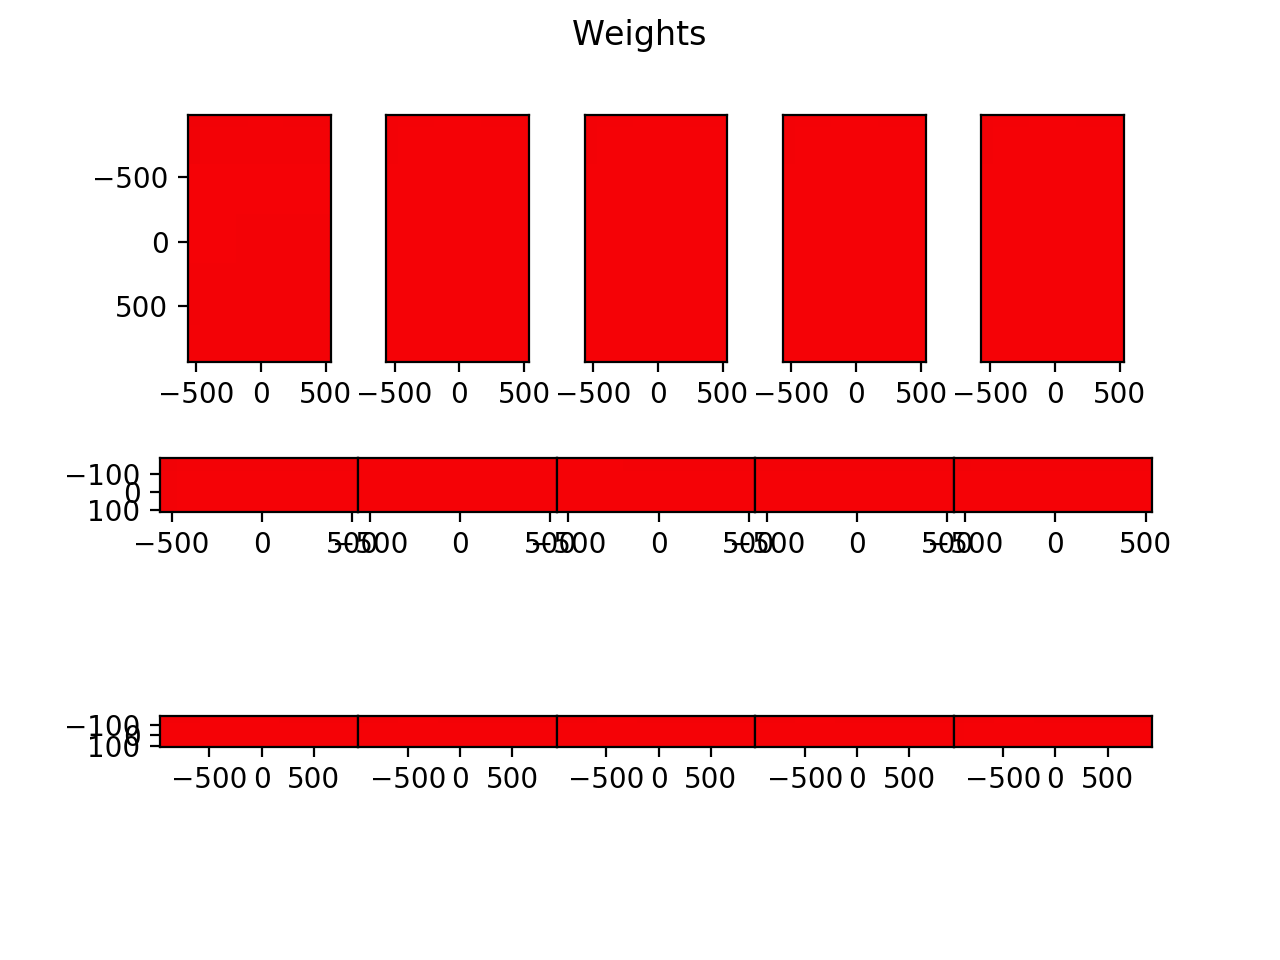

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


In [18]:
# now we want to register
# we'll start with an affine registration
import imp
imp.reload(emlddmm)
config0 = {
    'device':'cpu',
    'n_iter':500, 'downI':[2,2,2], 'downJ':[2,2,2],
     'priors':[0.9,0.05,0.05],'update_priors':False,
     'update_muA':0,'muA':[np.quantile(J,0.99)],
     'update_muB':0,'muB':[0.0],     
     'sigmaM':1.0,'sigmaB':2.0,'sigmaA':5.0,
     'order':1,'n_draw':50,'n_estep':3,'slice_matching':0,'v_start':1000,
     'eA':5e6,'A':A0,'full_outputs':True,'local_contrast':[1,100,100]
   }




I_ = np.concatenate((I,I**2))
out = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=target_data['W'], **config0)

In [19]:
np.linalg.det(out['A']),out['A'][0,0]

(1.139439, tensor(1.1174))

/home/dtward/data/csh_data/emlddmm/emlddmm.py:970: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A,device=device,dtype=dtype).detach().clone()


<IPython.core.display.Javascript object>


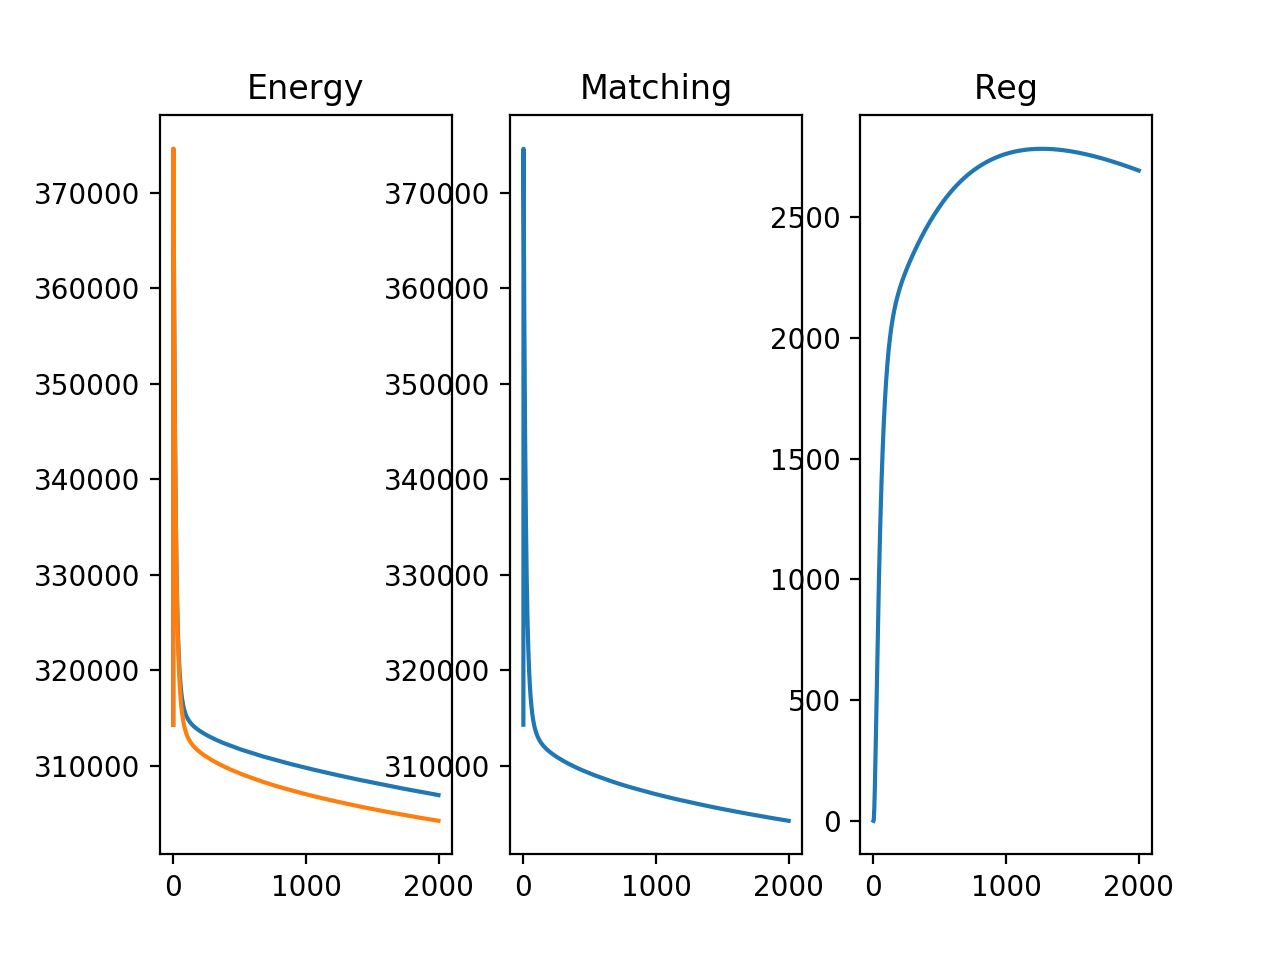

<IPython.core.display.Javascript object>


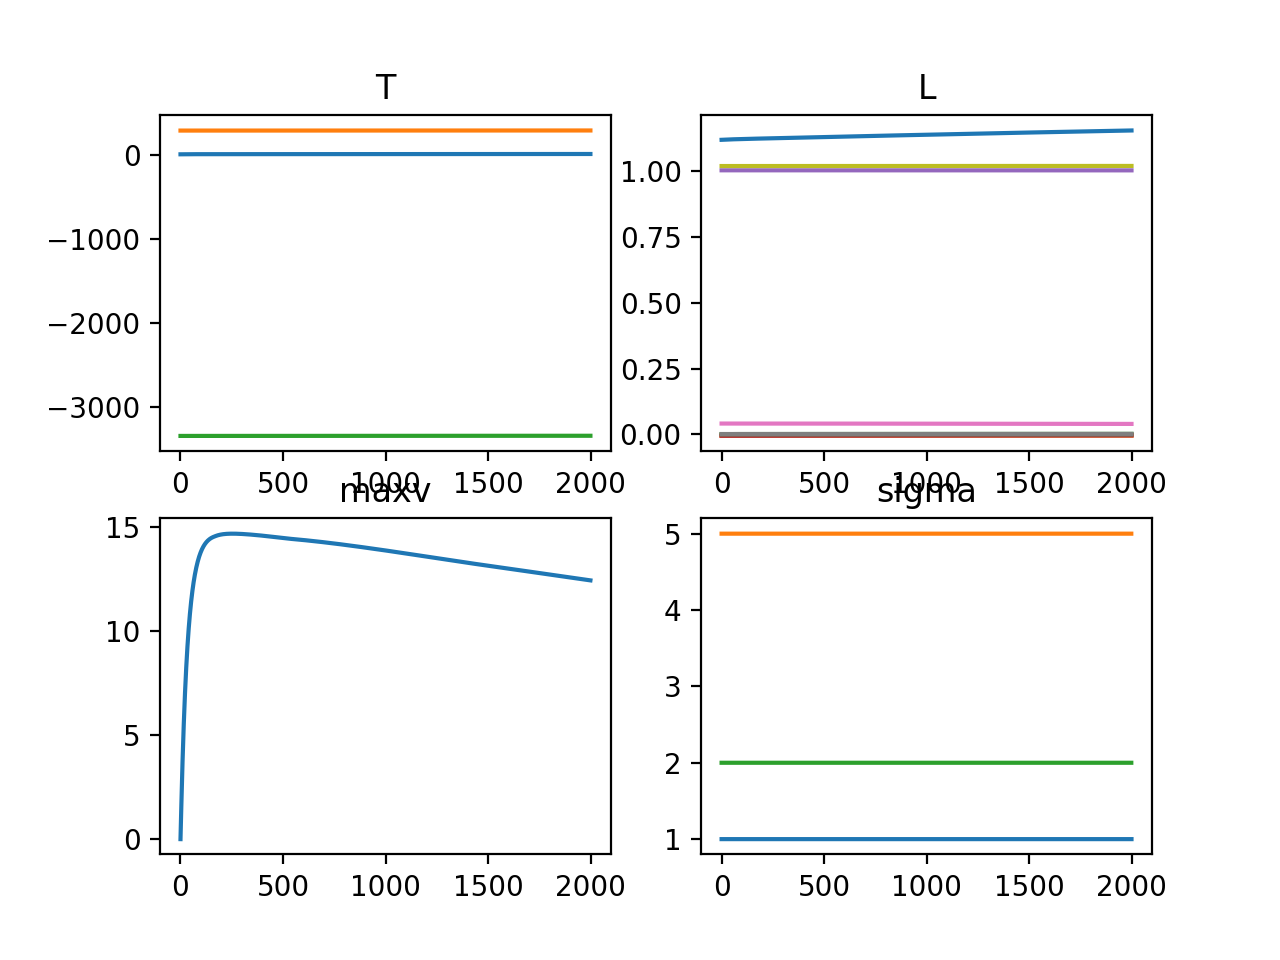

<IPython.core.display.Javascript object>


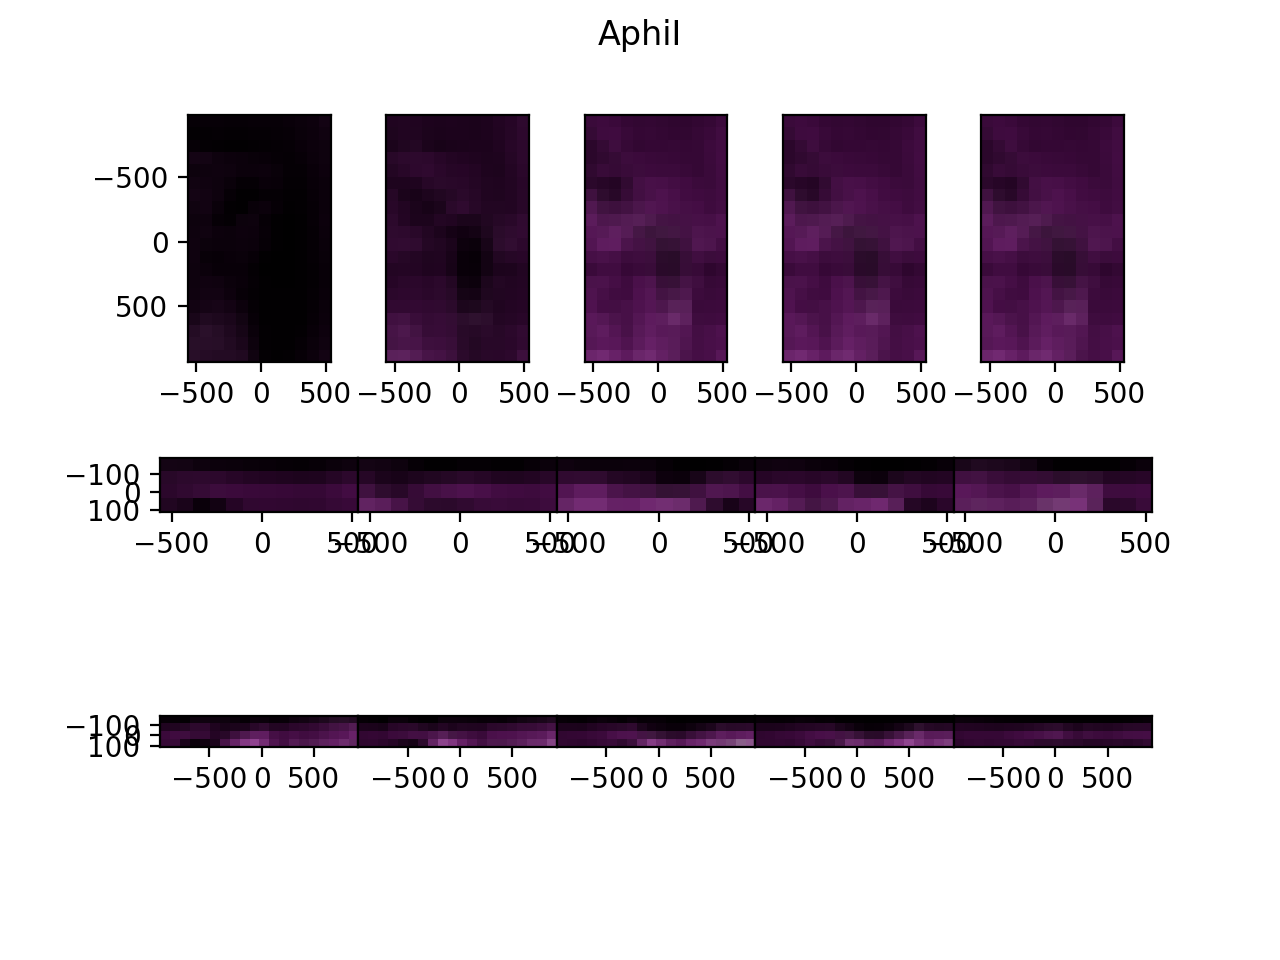

<IPython.core.display.Javascript object>


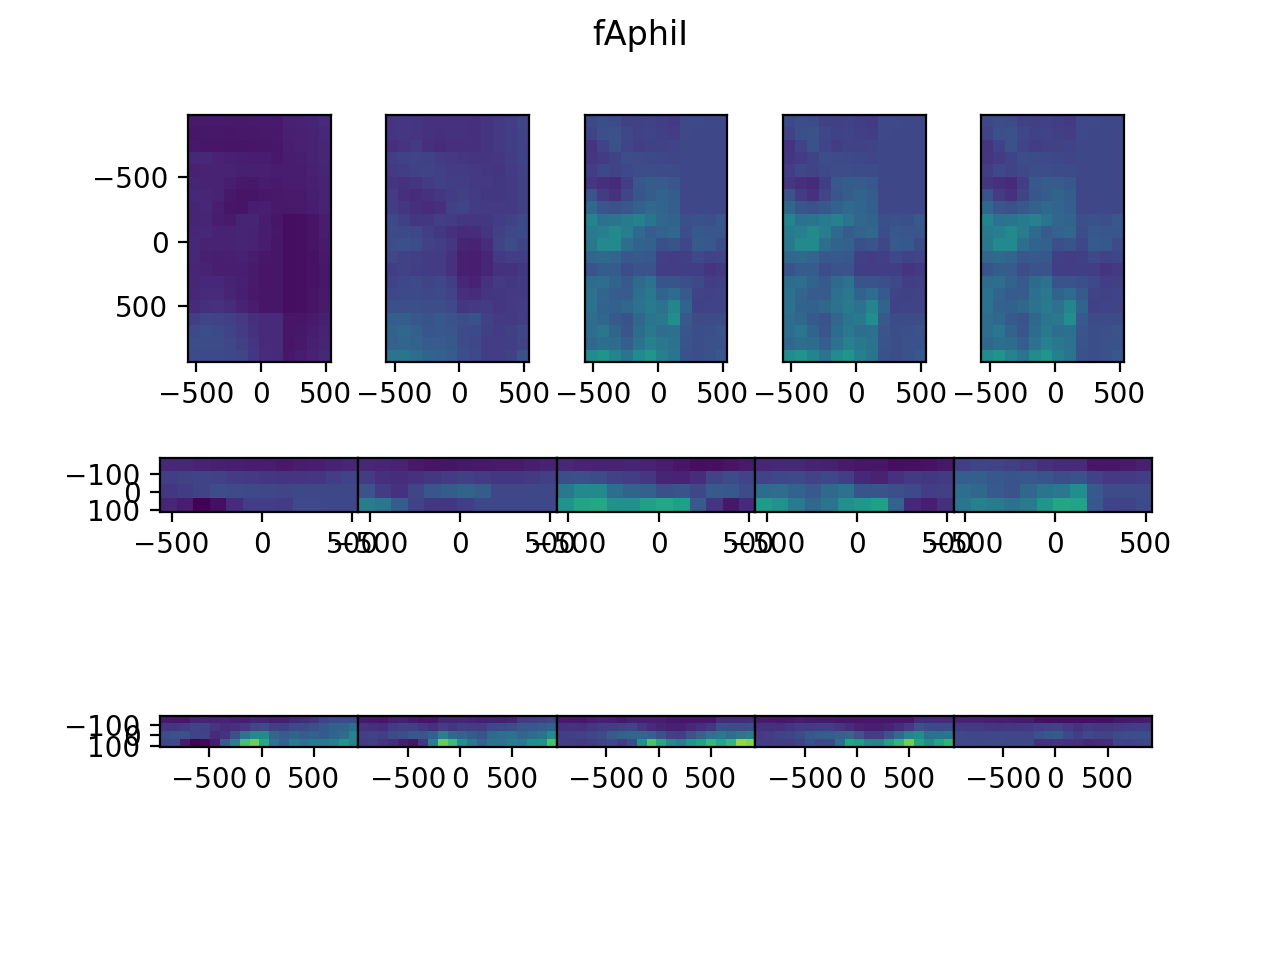

<IPython.core.display.Javascript object>


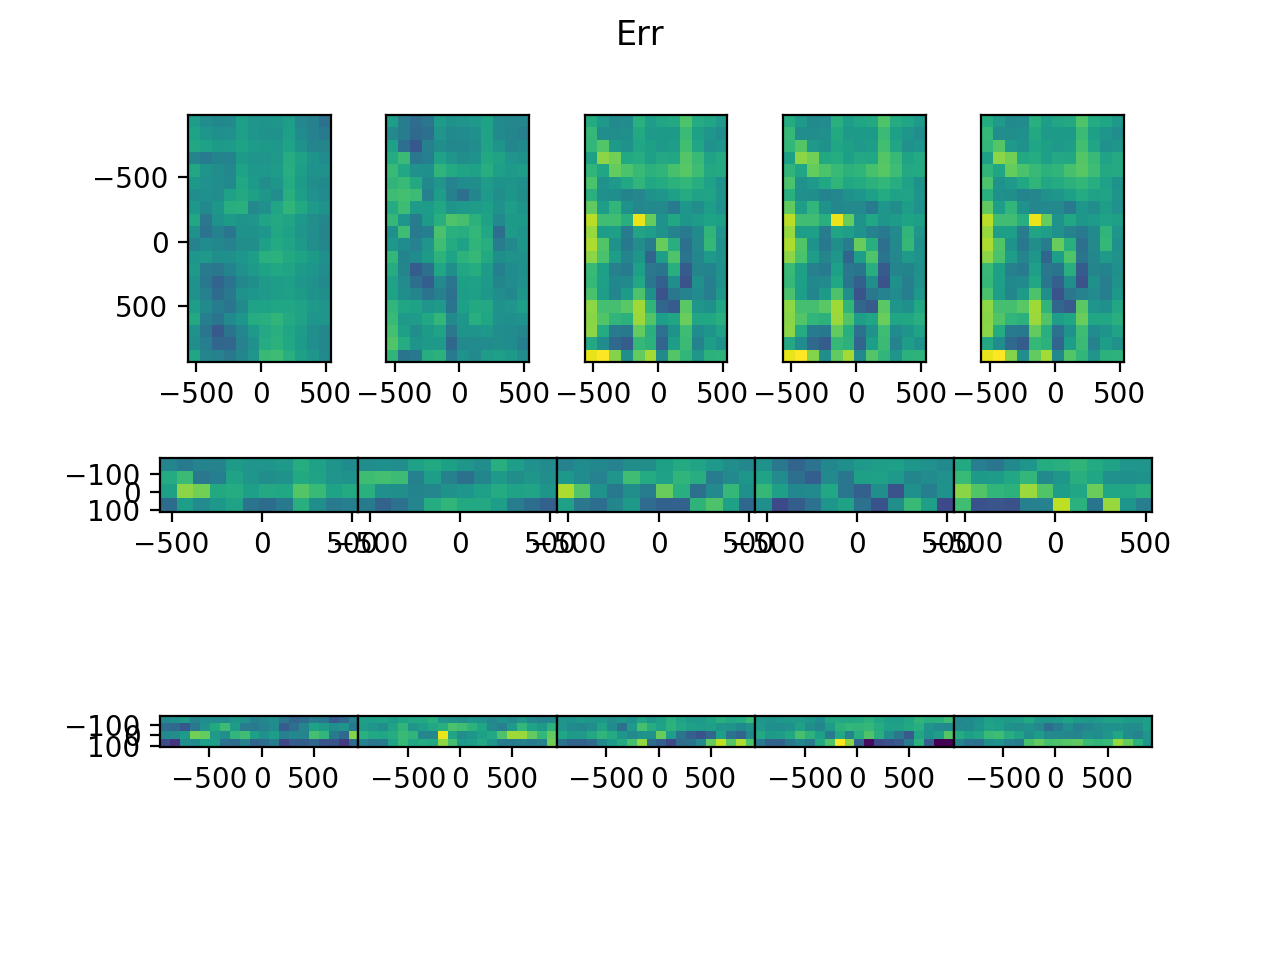

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1027: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figJ = plt.figure()


<IPython.core.display.Javascript object>


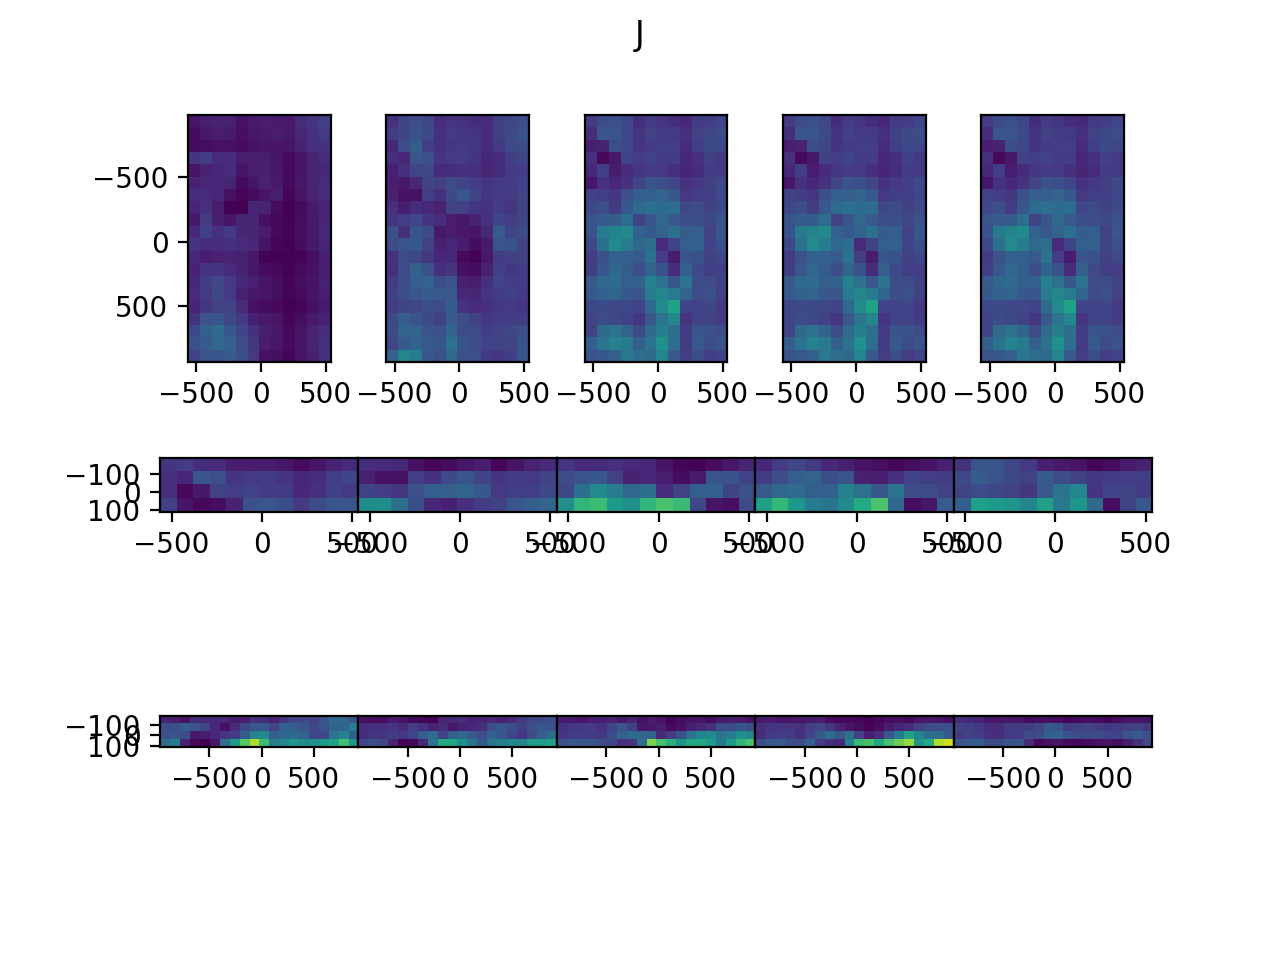

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1028: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figV = plt.figure()


<IPython.core.display.Javascript object>


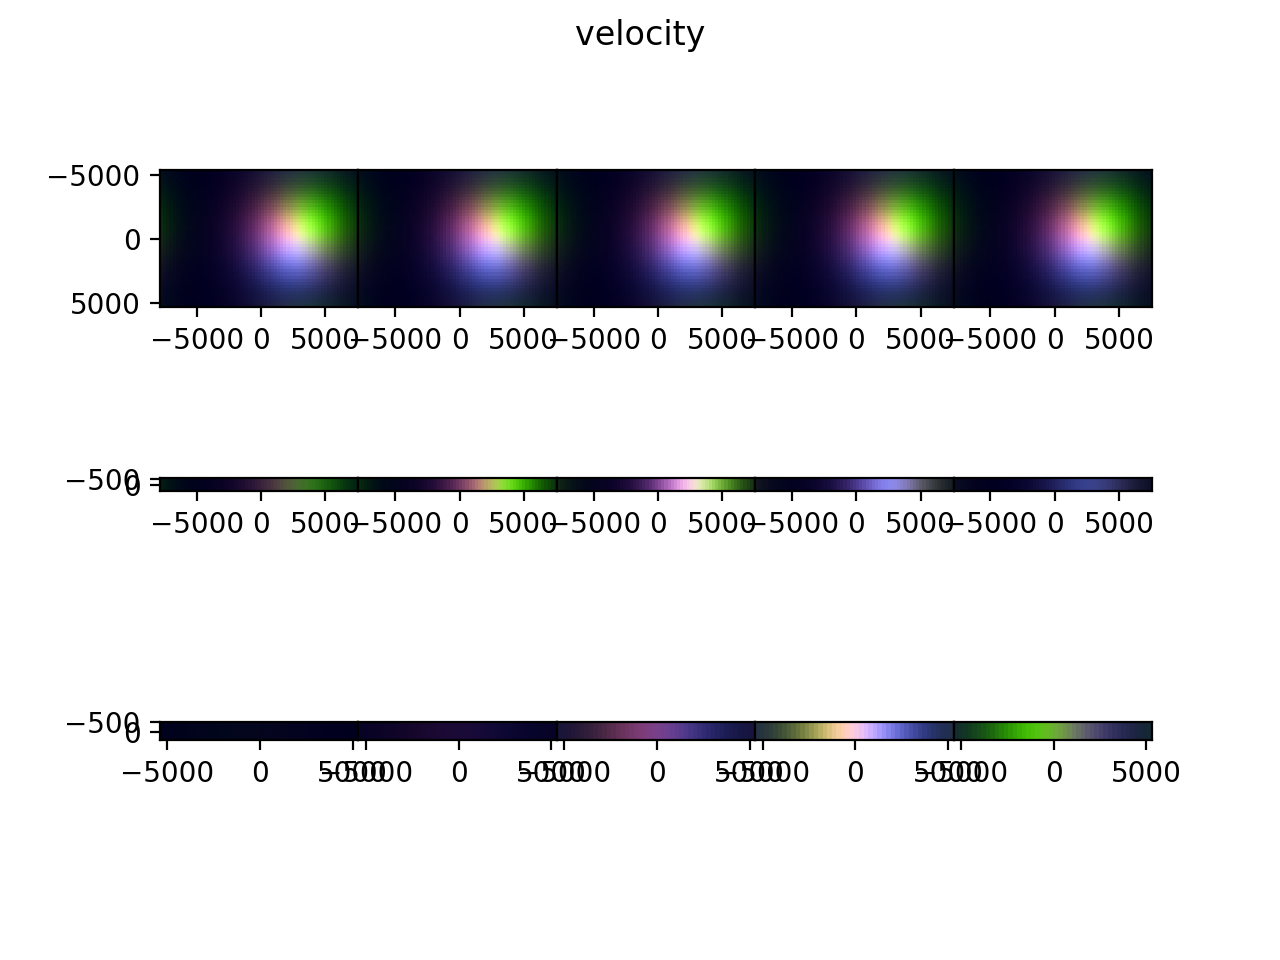

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1029: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figW = plt.figure()


<IPython.core.display.Javascript object>


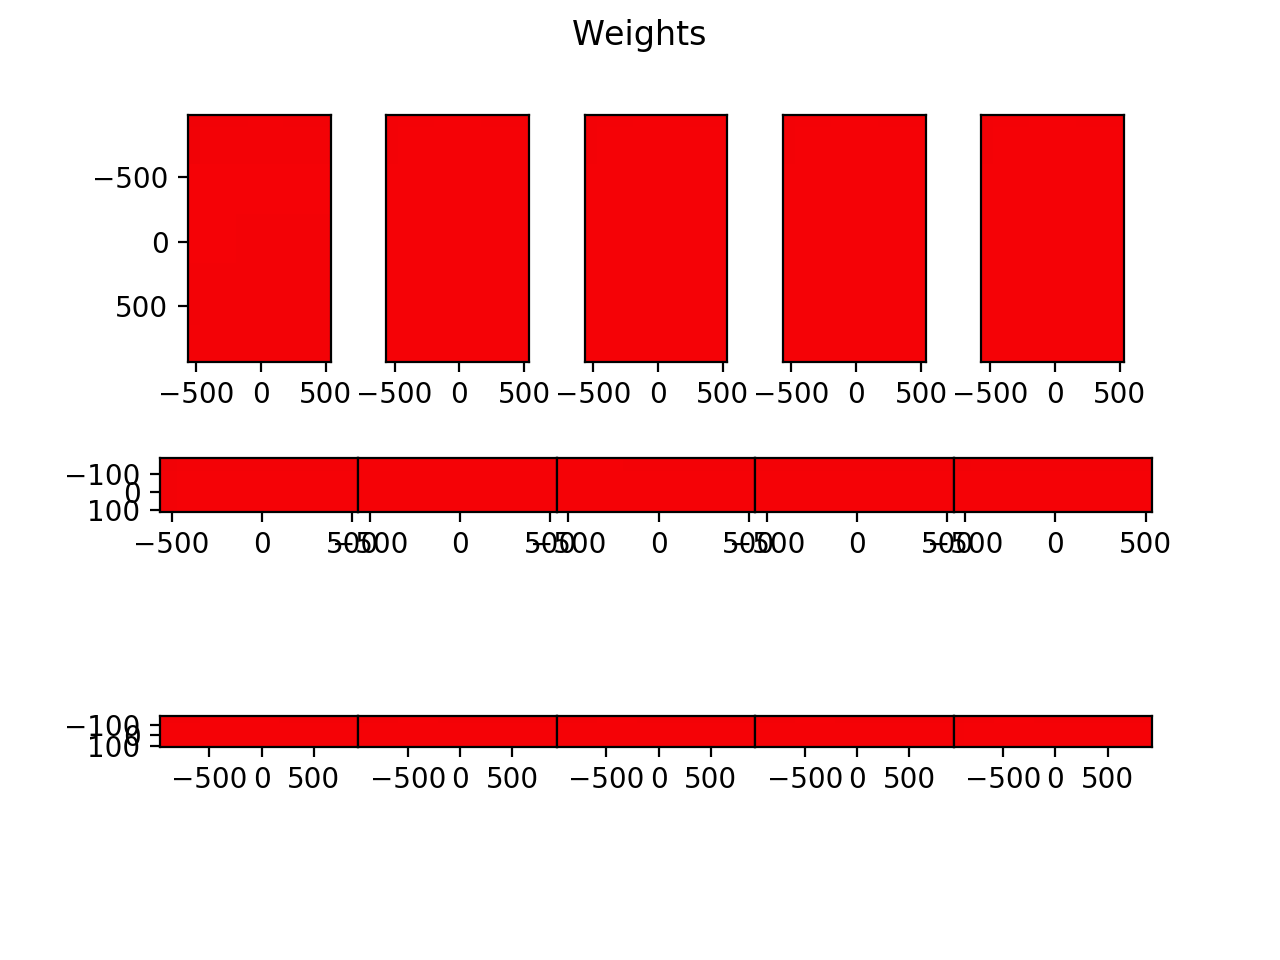

Iteration 150, linear oscilating, reducing eA to 450000.0


In [20]:
# second run, with deformation
imp.reload(emlddmm)
config1 = dict(config0)

config1['A'] = out['A']
config1['eA'] = config0['eA']*0.1
config1['a'] = 1000.0
config1['sigmaR'] = 5e4 # 1e4 gave really good results, but try 2e4, also good, I showed this in my slides
config1['n_iter']= 2000
config1['v_start'] = 0
config1['ev'] = 1e0
config1['v_res_factor'] = config1['a']/dI[0]/2/2 # what is the resolution of v, as a multiple of that in I

config1['device'] = 'cpu'
# changing my inverses to double did not fix the issue
#config1['device'] = 'cuda:1'
config1['local_contrast'] = [2,8,8]


out1 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=target_data['W'], **config1)

/home/dtward/data/csh_data/emlddmm/emlddmm.py:955: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v,device=device,dtype=dtype)
/home/dtward/data/csh_data/emlddmm/emlddmm.py:1018: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figE,axE = plt.subplots(1,3)


<IPython.core.display.Javascript object>


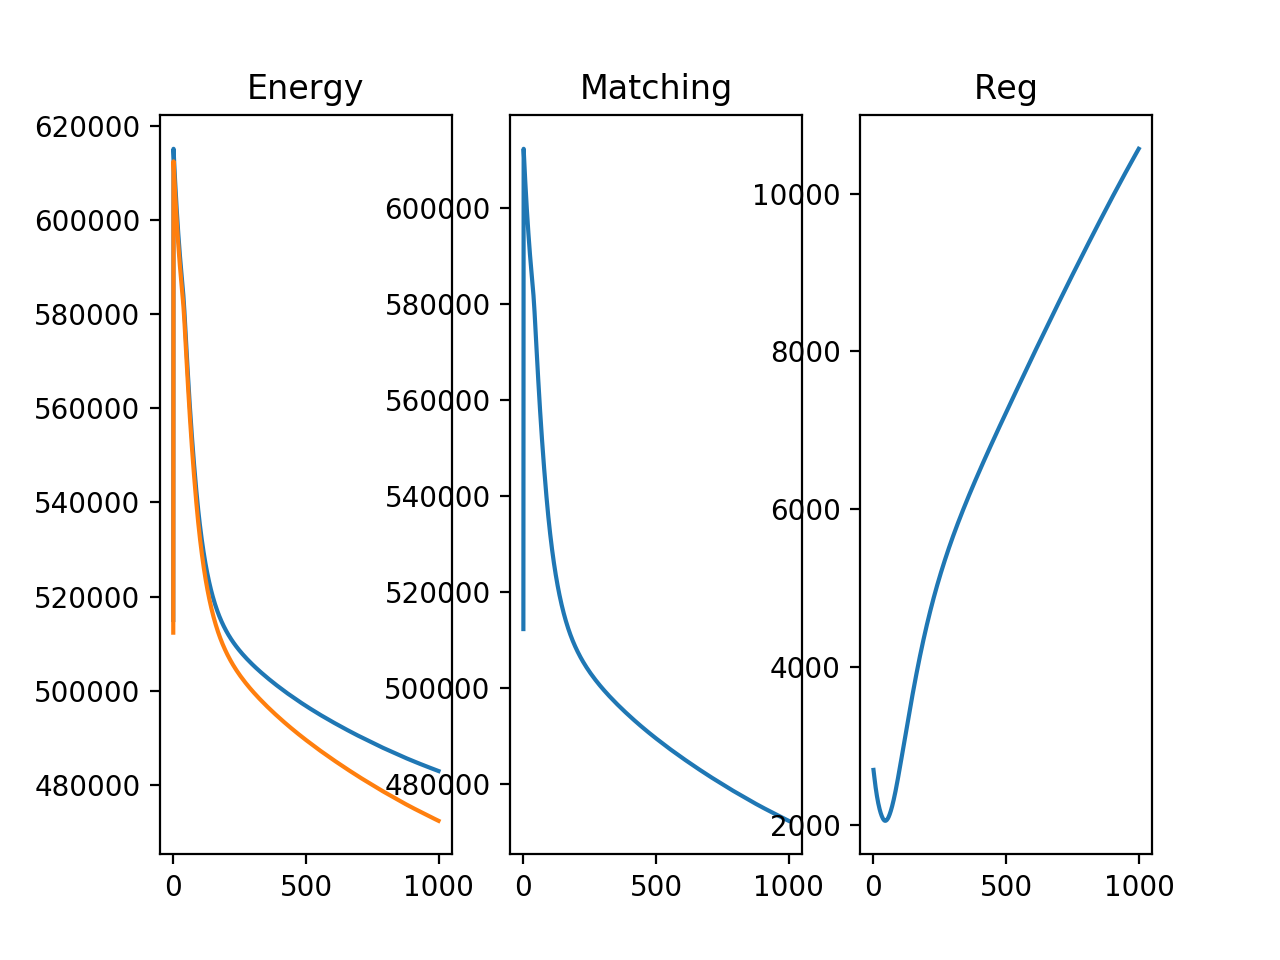

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1019: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figA,axA = plt.subplots(2,2)


<IPython.core.display.Javascript object>


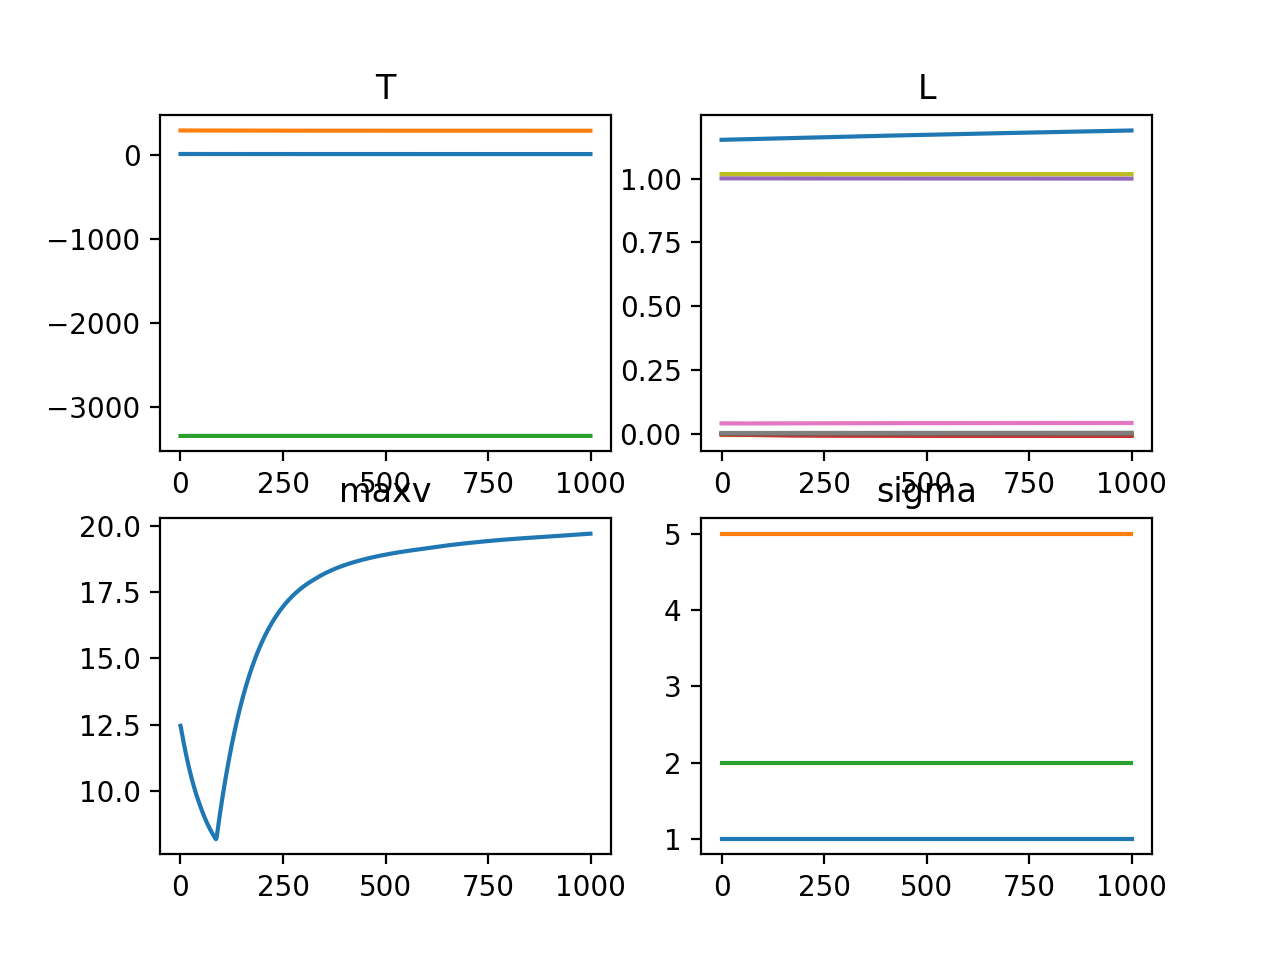

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1024: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figI = plt.figure()


<IPython.core.display.Javascript object>


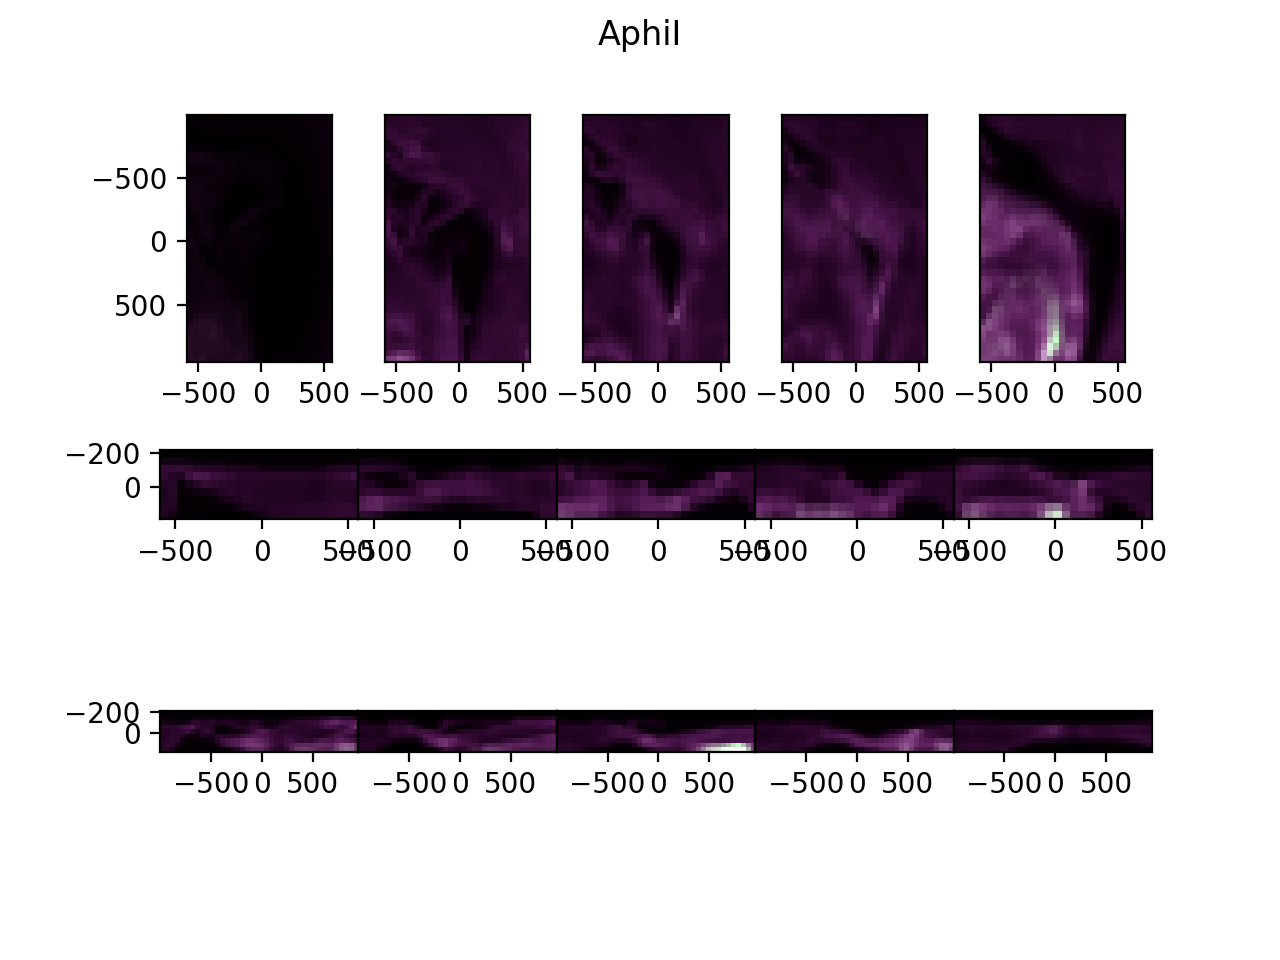

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1025: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figfI = plt.figure()


<IPython.core.display.Javascript object>


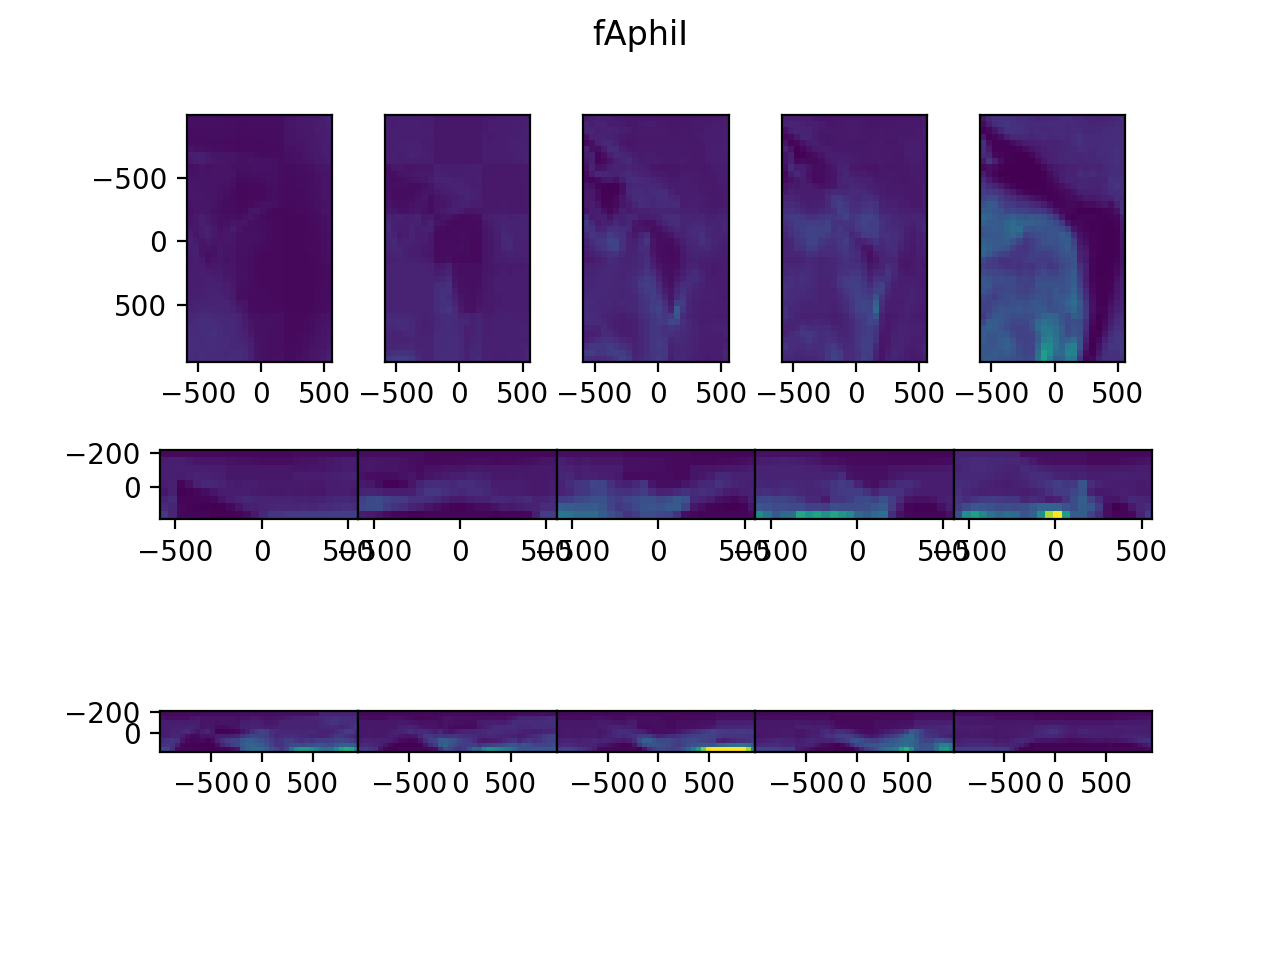

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1026: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figErr = plt.figure()


<IPython.core.display.Javascript object>


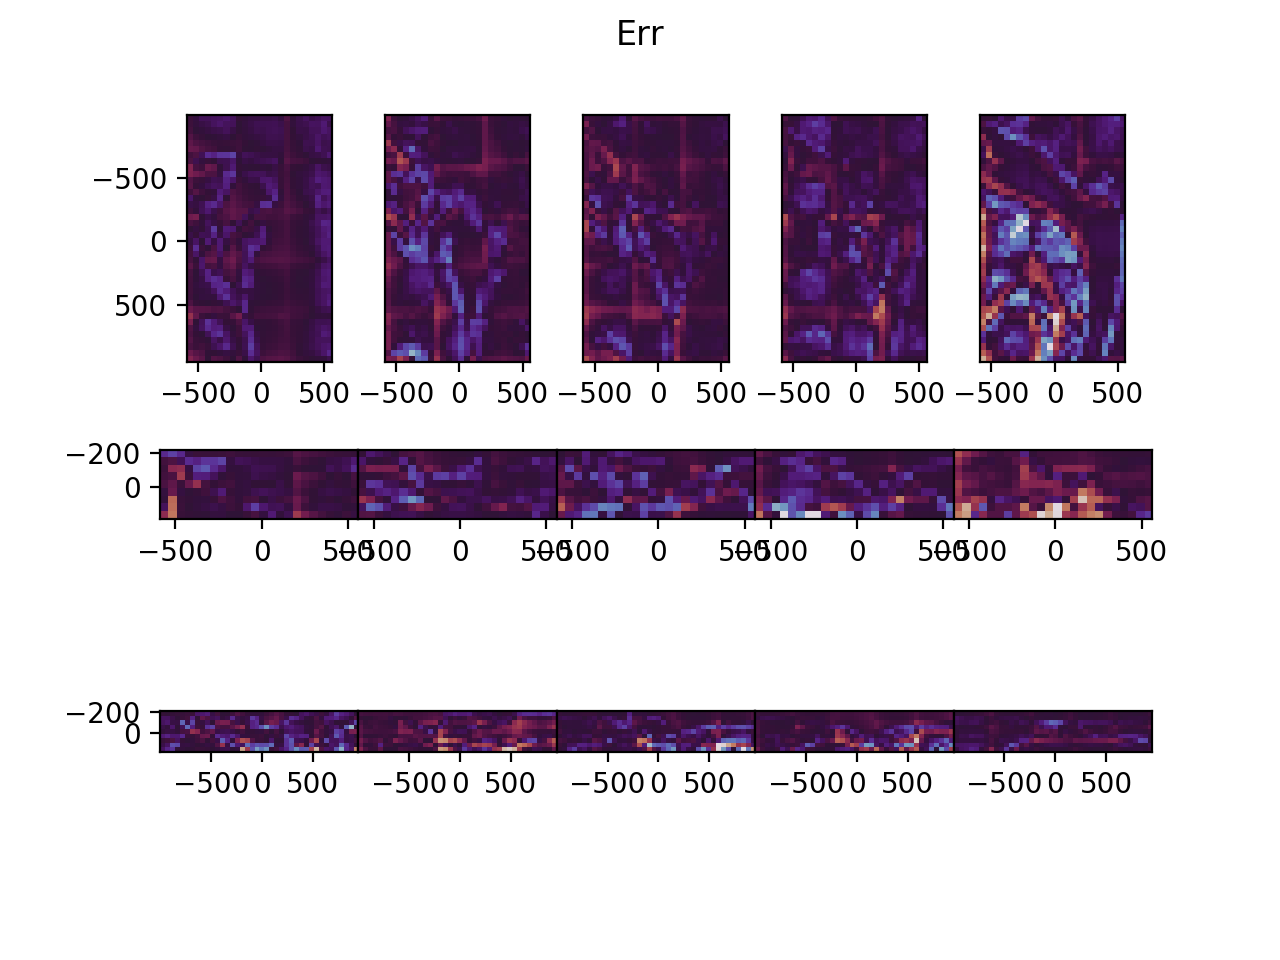

<IPython.core.display.Javascript object>


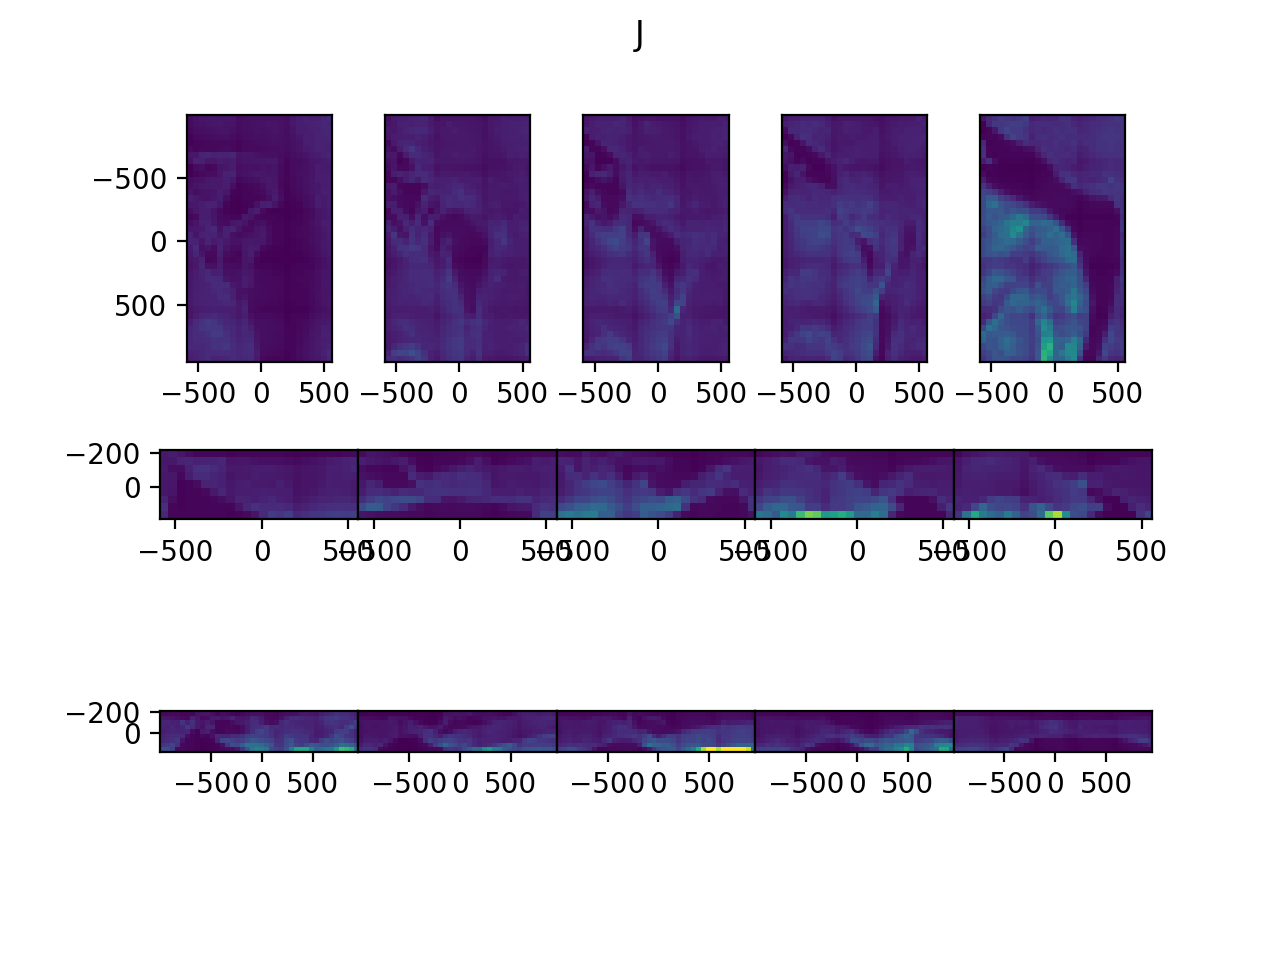

<IPython.core.display.Javascript object>


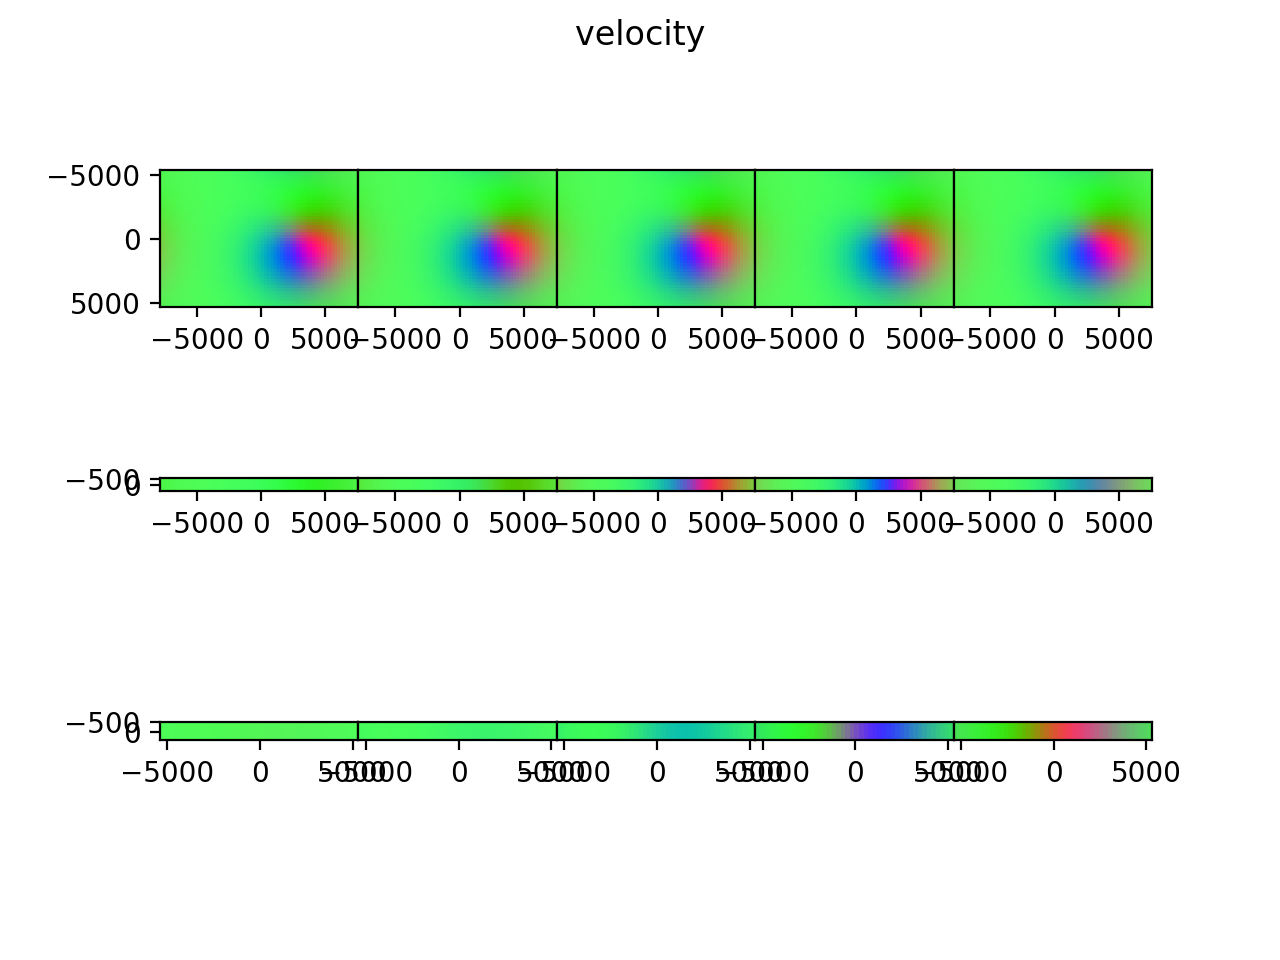

<IPython.core.display.Javascript object>


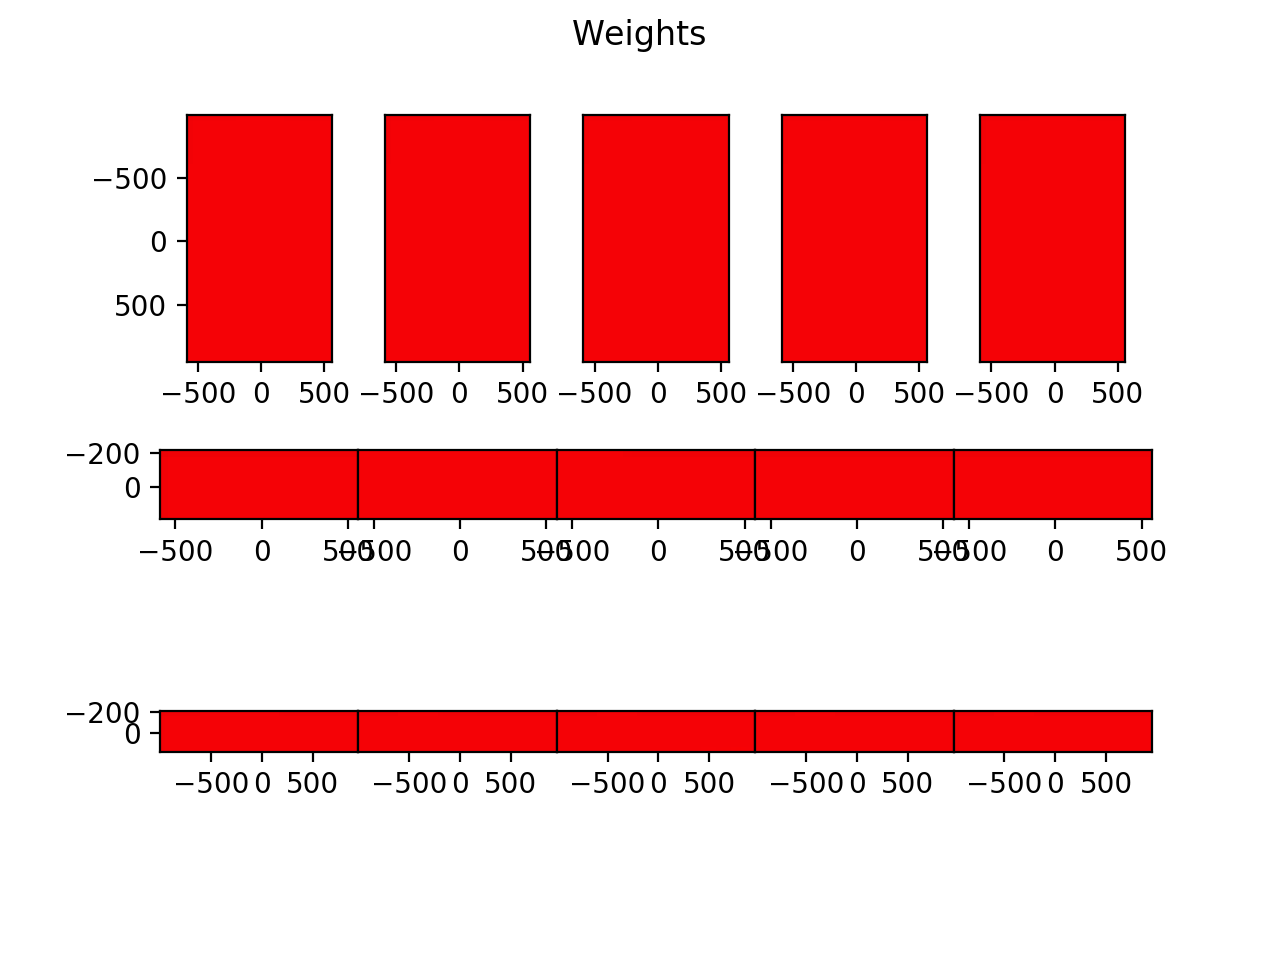

In [21]:
imp.reload(emlddmm)
# on the next run we do les downsampling
config2 = dict(config1)
config2['A'] = out1['A']
config2['n_iter']= 1000
config2['v'] = out1['v']
config2['downI'] = [1,1,1]
config2['downJ'] = [1,1,1]
config2['ev'] = config1['ev']*0.5
config2['eA'] = config1['eA']*0.5
# there seems to be an issue with the initial velocity
# when I run this twice, I'm reusing it
out2 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=target_data['W'], **config2)
# the matching energy here is way way lower, why would that be?

In [22]:
# save the outputs
savename = f'transformation_outputs_{target_key}_dragonfly10to30_v00.npz'
np.savez(output_prefix+savename,out=out2)

In [23]:
out2['figI'].savefig(output_prefix + target_key + '_transformed.jpg',**figopts)
out2['figfI'].savefig(output_prefix + target_key + '_contrast.jpg',**figopts)
out2['figErr'].savefig(output_prefix + target_key + '_err.jpg',**figopts)

4294967296 4294967296
4294967296 4294967296
4294967296 4294967296


In [24]:
fig = out2['figErr']
axs = fig.get_axes()
for ax in axs:
    ims = ax.get_images()
    for im in ims:
        im.set_cmap('twilight')
        clim = im.get_clim()
        lim = np.max(np.abs(clim))
        im.set_clim(np.array((-1,1))*lim)
fig.canvas.draw()
fig.savefig(output_prefix + target_key + '_err2.jpg',**figopts)

4294967296 4294967296


/home/dtward/data/csh_data/emlddmm/emlddmm.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


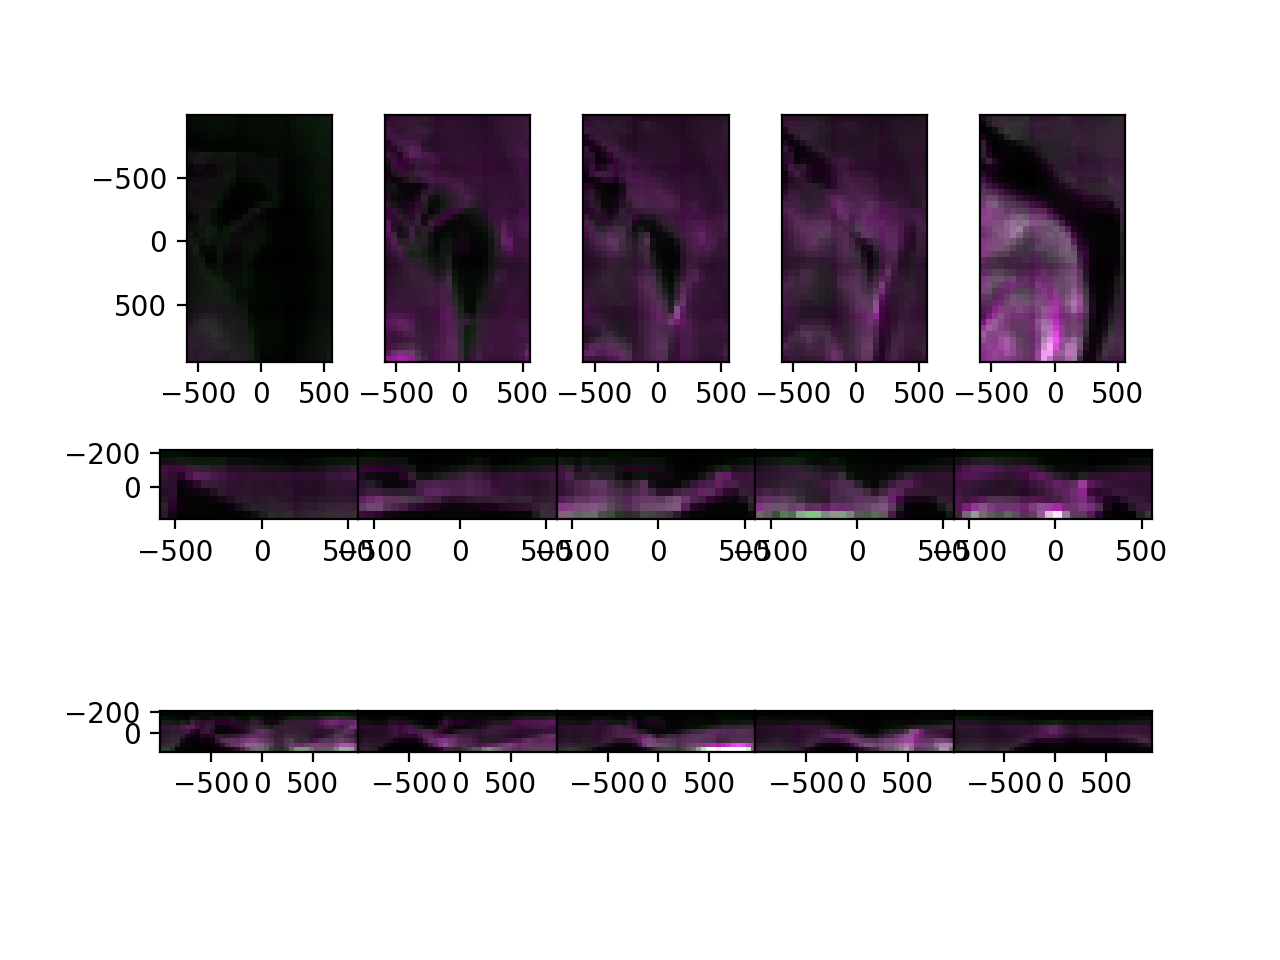

4294967296 4294967296


In [25]:
# vualize overlap as above

# check it
XJ = np.meshgrid(*xJ,indexing='ij')

tform = emlddmm.compose_sequence([emlddmm.Transform(out2['A'],'b'),
                                  emlddmm.Transform(out2['v'],'b',domain=out2['xv'])],XJ)
AI = emlddmm.apply_transform_float(xI,I,tform)
fig,ax = emlddmm.draw(np.concatenate((AI,J)),xJ,vmin=0)
fig.canvas.draw()
fig.savefig(output_prefix + target_key + '_err3.jpg',**figopts)

In [26]:
out2['A']

tensor([[ 1.1895e+00, -4.3401e-03,  2.0492e-03,  1.0132e+01],
        [-9.2288e-03,  1.0008e+00, -3.8625e-03,  2.8757e+02],
        [ 4.1614e-02,  3.1370e-03,  1.0181e+00, -3.3400e+03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [27]:
# write the outputs

In [28]:
# I need to save the outputs in a format I can use later for composing.

In [29]:
target_key

'09B'